In [292]:
import os
import pickle 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [297]:
# Define file path and chunk size
TRAIN_FILE_PATH = r"C:\Users\spand\Projects\MICROSOFT_CYBERSECURITY\Guvi---Microsoft-Cybersecurity\Data\Raw\new_train_sample.csv"  
TEST_FILE_PATH = r"C:\Users\spand\Projects\MICROSOFT_CYBERSECURITY\Guvi---Microsoft-Cybersecurity\Data\Raw\GUIDE_Test.csv"
CHUNK_SIZE = 50000  

In [298]:
# Function to load a large dataset easily
def data_loader(file_path, chunksize=CHUNK_SIZE):
    """
    Loads a large CSV file efficiently in chunks, cleans it, and combines it into a single DataFrame.

    Args:
        file_path (str): Path to the CSV file to be loaded.
        chunksize (int): Number of rows per chunk to load into memory. Default is CHUNK_SIZE.

    Returns:
        DataFrame: A cleaned, combined DataFrame with all chunks concatenated.
    """

    chunk_list = []  # List to store processed chunks

    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
        chunk = chunk.drop(columns=['Unnamed: 0'], errors='ignore')
        chunk_list.append(chunk)  # Append each chunk to the list
    
    # Combine all chunks into a single DataFrame
    full_data = pd.concat(chunk_list, ignore_index=True)
    return full_data

In [ ]:
# Load the full training dataset
train_data = data_loader(TRAIN_FILE_PATH)
pd.set_option('display.max_columns', None)
train_data.head() 

In [ ]:
# Basic Exploration
print(f"Dataset shape: {train_data.shape}\n")
print("Columns in the dataset:")
print(train_data.columns)

Dataset shape: (4758418, 45)

Columns in the dataset:
Index(['Id', 'OrgId', 'IncidentId', 'AlertId', 'Timestamp', 'DetectorId',
       'AlertTitle', 'Category', 'MitreTechniques', 'IncidentGrade',
       'ActionGrouped', 'ActionGranular', 'EntityType', 'EvidenceRole',
       'DeviceId', 'Sha256', 'IpAddress', 'Url', 'AccountSid', 'AccountUpn',
       'AccountObjectId', 'AccountName', 'DeviceName', 'NetworkMessageId',
       'EmailClusterId', 'RegistryKey', 'RegistryValueName',
       'RegistryValueData', 'ApplicationId', 'ApplicationName',
       'OAuthApplicationId', 'ThreatFamily', 'FileName', 'FolderPath',
       'ResourceIdName', 'ResourceType', 'Roles', 'OSFamily', 'OSVersion',
       'AntispamDirection', 'SuspicionLevel', 'LastVerdict', 'CountryCode',
       'State', 'City'],
      dtype='object')


In [ ]:
print("Data type of columns in the dataset:")
print(train_data.dtypes)

Data type of columns in the dataset:
Id                      int64
OrgId                   int64
IncidentId              int64
AlertId                 int64
Timestamp              object
DetectorId              int64
AlertTitle              int64
Category               object
MitreTechniques        object
IncidentGrade          object
ActionGrouped          object
ActionGranular         object
EntityType             object
EvidenceRole           object
DeviceId                int64
Sha256                  int64
IpAddress               int64
Url                     int64
AccountSid              int64
AccountUpn              int64
AccountObjectId         int64
AccountName             int64
DeviceName              int64
NetworkMessageId        int64
EmailClusterId        float64
RegistryKey             int64
RegistryValueName       int64
RegistryValueData       int64
ApplicationId           int64
ApplicationName         int64
OAuthApplicationId      int64
ThreatFamily           object
Fil

In [ ]:
# Display distribution of target variable
print("\n--- TARGET VARIABLE DISTRIBUTION ---")
print(train_data['IncidentGrade'].value_counts(), '\n')
print(train_data['IncidentGrade'].value_counts(normalize=True) * 100)


--- TARGET VARIABLE DISTRIBUTION ---
IncidentGrade
BenignPositive    2054774
TruePositive      1662087
FalsePositive     1015782
Name: count, dtype: int64 

IncidentGrade
BenignPositive    43.417050
TruePositive      35.119636
FalsePositive     21.463313
Name: proportion, dtype: float64


In [ ]:
# Check for missing values
print("\n--- MISSING VALUES DATA ---")
missing = train_data.isnull().sum()
missing_percent = (missing / len(train_data)) * 100
missing_df = pd.DataFrame({'Missing Values': missing, 'Missing Percentage': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Missing Values', ascending=False))


--- MISSING VALUES DATA ---
                   Missing Values  Missing Percentage
ResourceType              4754863           99.925290
ActionGranular            4730205           99.407093
ActionGrouped             4730205           99.407093
ThreatFamily              4721038           99.214445
EmailClusterId            4710241           98.987542
AntispamDirection         4669846           98.138625
Roles                     4649117           97.702997
SuspicionLevel            4037145           84.842168
LastVerdict               3642221           76.542687
MitreTechniques           2733136           57.437913
IncidentGrade               25775            0.541672


In [ ]:
# DATA CLEANING
print("\n--- DATA CLEANING ---")

# Create a copy of the dataframe for cleaning
clean_df = train_data.copy()

# Drop columns with >50% missing values
print("Dropping columns with >50% missing values...")
clean_df = clean_df.drop(missing_percent[missing_percent > 50].index, axis=1)

# Drop rows with null values in target variable 
print("Dropping rows with null values in target variable ...")
clean_df = clean_df.dropna(subset=['IncidentGrade'])

# Convert Timestamp to datetime if it's not already
if clean_df['Timestamp'].dtype == 'object':
    print("Converting Timestamp to datetime...")
    clean_df['Timestamp'] = pd.to_datetime(clean_df['Timestamp'], errors='coerce')
    
    # Extract time-related features
    clean_df['Hour'] = clean_df['Timestamp'].dt.hour
    clean_df['Day'] = clean_df['Timestamp'].dt.day
    clean_df['DayOfWeek'] = clean_df['Timestamp'].dt.dayofweek
    clean_df['Month'] = clean_df['Timestamp'].dt.month
    clean_df['Year'] = clean_df['Timestamp'].dt.year
    clean_df = clean_df.drop('Timestamp', axis=1)

# Remove duplicates if any
duplicates = clean_df.duplicated().sum()
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    clean_df = clean_df.drop_duplicates()

print(f"Shape after cleaning: {clean_df.shape}")


--- DATA CLEANING ---
Dropping columns with >50% missing values...
Dropping rows with null values in target variable ...
Converting Timestamp to datetime...
Removing 155243 duplicate rows...
Shape after cleaning: (4577400, 39)


In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4577400 entries, 0 to 4758417
Data columns (total 39 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   Id                  int64 
 1   OrgId               int64 
 2   IncidentId          int64 
 3   AlertId             int64 
 4   DetectorId          int64 
 5   AlertTitle          int64 
 6   Category            object
 7   IncidentGrade       object
 8   EntityType          object
 9   EvidenceRole        object
 10  DeviceId            int64 
 11  Sha256              int64 
 12  IpAddress           int64 
 13  Url                 int64 
 14  AccountSid          int64 
 15  AccountUpn          int64 
 16  AccountObjectId     int64 
 17  AccountName         int64 
 18  DeviceName          int64 
 19  NetworkMessageId    int64 
 20  RegistryKey         int64 
 21  RegistryValueName   int64 
 22  RegistryValueData   int64 
 23  ApplicationId       int64 
 24  ApplicationName     int64 
 25  OAuthApplicationId  int

In [ ]:
clean_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4577400.0,8.419716e+11,4.965472e+11,0.0,4.123169e+11,8.418136e+11,1.271310e+12,1.709397e+12
OrgId,4577400.0,1.730889e+02,3.731760e+02,0.0,9.000000e+00,4.200000e+01,1.610000e+02,6.129000e+03
IncidentId,4577400.0,6.973234e+04,1.203110e+05,0.0,4.630000e+02,9.215000e+03,8.201100e+04,5.997030e+05
AlertId,4577400.0,4.110693e+05,4.605476e+05,0.0,2.135500e+04,2.218820e+05,6.850460e+05,1.721456e+06
DetectorId,4577400.0,1.096099e+02,4.252050e+02,0.0,2.000000e+00,9.000000e+00,4.600000e+01,9.522000e+03
AlertTitle,4577400.0,2.862698e+03,1.106618e+04,0.0,2.000000e+00,1.300000e+01,1.950000e+02,1.131730e+05
DeviceId,4577400.0,9.556584e+04,1.659709e+04,0.0,9.879900e+04,9.879900e+04,9.879900e+04,9.879900e+04
Sha256,4577400.0,1.283791e+05,3.454983e+04,0.0,1.382680e+05,1.382680e+05,1.382680e+05,1.382680e+05
IpAddress,4577400.0,2.829348e+05,1.430936e+05,0.0,3.606060e+05,3.606060e+05,3.606060e+05,3.606060e+05
Url,4577400.0,1.506187e+05,3.711049e+04,0.0,1.603960e+05,1.603960e+05,1.603960e+05,1.603960e+05


In [ ]:
clean_df.nunique()

Id                     642342
OrgId                    5236
IncidentId             421530
AlertId               1150459
DetectorId               7369
AlertTitle              74710
Category                   20
IncidentGrade               3
EntityType                 31
EvidenceRole                2
DeviceId                55204
Sha256                  73078
IpAddress              195384
Url                     85332
AccountSid             265788
AccountUpn             394186
AccountObjectId        257733
AccountName            272375
DeviceName              80956
NetworkMessageId       260032
RegistryKey               937
RegistryValueName         401
RegistryValueData         496
ApplicationId            1003
ApplicationName          1610
OAuthApplicationId        416
FileName               142641
FolderPath              59652
ResourceIdName           1497
OSFamily                    6
OSVersion                  48
CountryCode               212
State                    1197
City      

In [ ]:
num_features = [feature for feature in clean_df.columns if clean_df[feature].dtype != 'O']
num_features

['Id',
 'OrgId',
 'IncidentId',
 'AlertId',
 'DetectorId',
 'AlertTitle',
 'DeviceId',
 'Sha256',
 'IpAddress',
 'Url',
 'AccountSid',
 'AccountUpn',
 'AccountObjectId',
 'AccountName',
 'DeviceName',
 'NetworkMessageId',
 'RegistryKey',
 'RegistryValueName',
 'RegistryValueData',
 'ApplicationId',
 'ApplicationName',
 'OAuthApplicationId',
 'FileName',
 'FolderPath',
 'ResourceIdName',
 'OSFamily',
 'OSVersion',
 'CountryCode',
 'State',
 'City',
 'Hour',
 'Day',
 'DayOfWeek',
 'Month',
 'Year']

In [ ]:
cat_features = [feature for feature in clean_df.columns if clean_df[feature].dtype == 'O']
cat_features

['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']

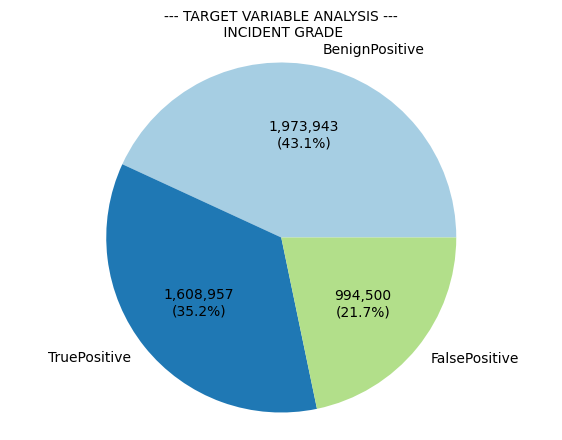

In [ ]:
# TARGET VARIABLE ANALYSIS
grade_counts = clean_df['IncidentGrade'].value_counts()
def autopct_format(pct, sizes = grade_counts.values):
    count = int(round(pct/100.*sum(sizes)))
    return f"{count:,}\n({pct:.1f}%)"

plt.figure(figsize=(7, 5))
plt.pie(grade_counts, labels=grade_counts.index, autopct=lambda pct: autopct_format(pct), colors=plt.cm.Paired.colors)
plt.title('--- TARGET VARIABLE ANALYSIS ---\n INCIDENT GRADE', fontsize=10)
plt.axis('equal') 
plt.show()

- The target variable (IncidentGrade) has 3 classes - False Positive, True Positive & Benign Positive (FP, TP & BP)
- There is visible class imbalance with BP class(43.1%) having twice as much data as the FP class(21.7%)

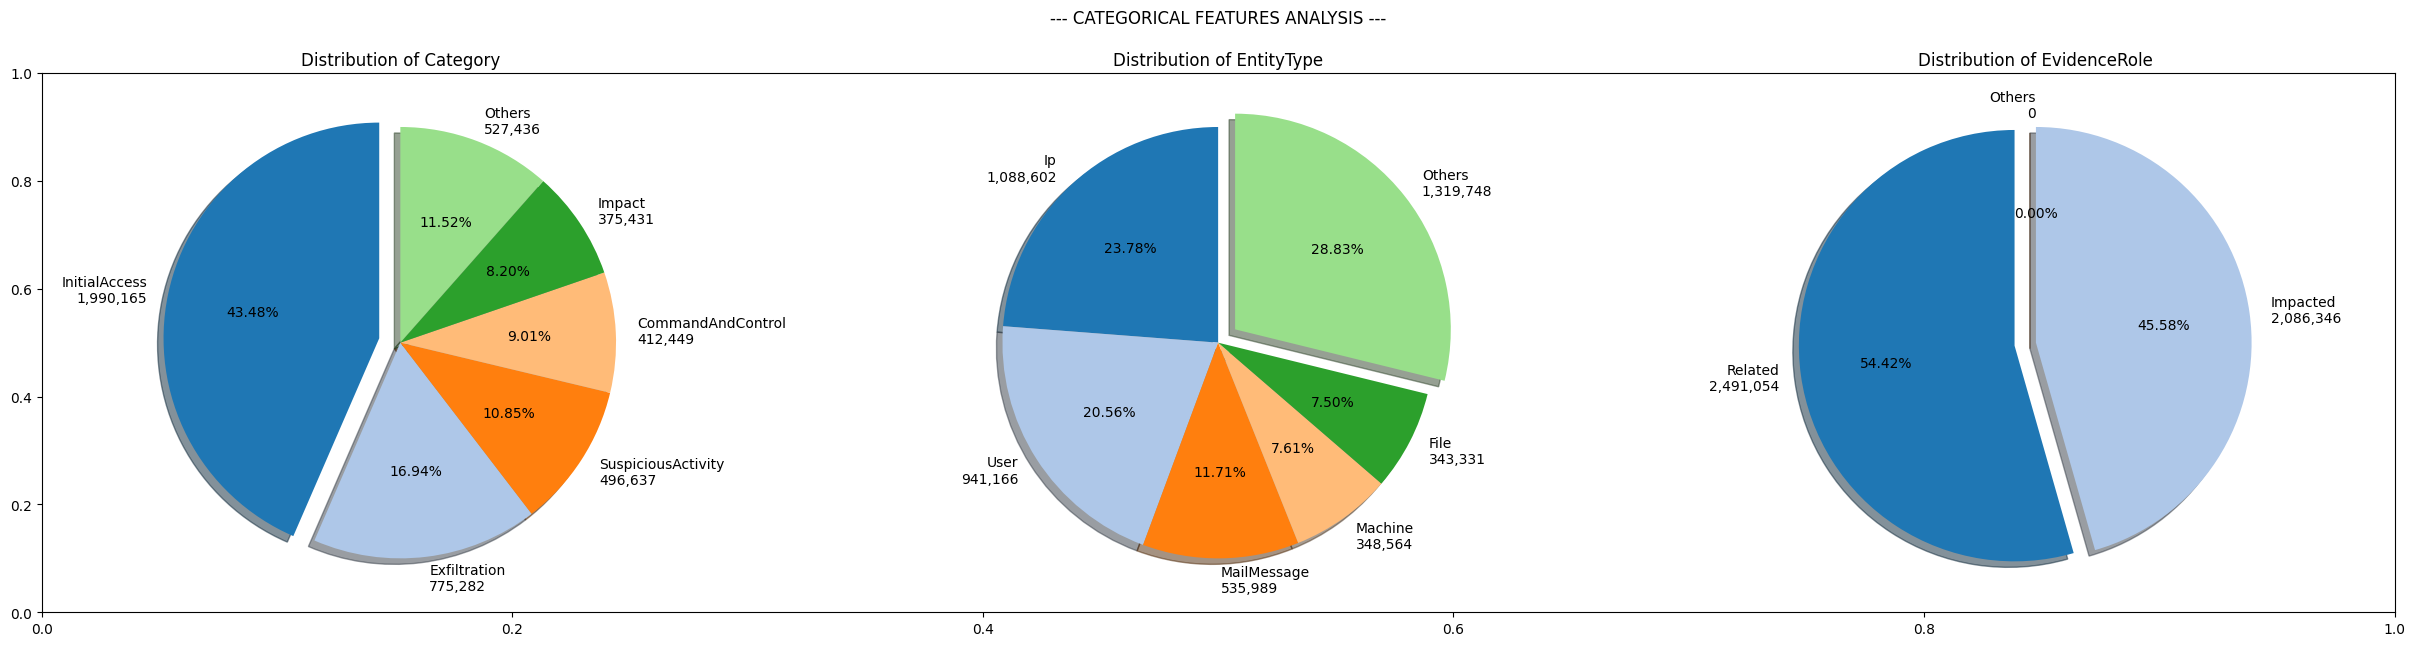

In [ ]:
# CATEGORICAL FEATURES ANALYSIS
plt.figure(figsize=(25, 7))
plt.title("--- CATEGORICAL FEATURES ANALYSIS ---\n\n")

cols = ['Category', 'EntityType', 'EvidenceRole']
for i, col in enumerate(cols):
    value_counts = clean_df[col].value_counts()
    
    top_5 = value_counts.nlargest(5)
    others = value_counts.iloc[5:].sum()
    top_5['Others'] = others
    
    labels = [f"{cat}\n{count:,}" for cat, count in top_5.items()]
    explode = [0.1 if cat == top_5.idxmax() else 0 for cat in top_5.index]
    colors = plt.cm.tab20.colors[:len(top_5)]

    # Plot pie chart
    plt.subplot(1, 3, i + 1)
    plt.title(f'\nDistribution of {col}')
    plt.pie(top_5, labels=labels, autopct='%2.2f%%', startangle=90, colors=colors, explode=explode, shadow=True)

plt.tight_layout()
plt.show()

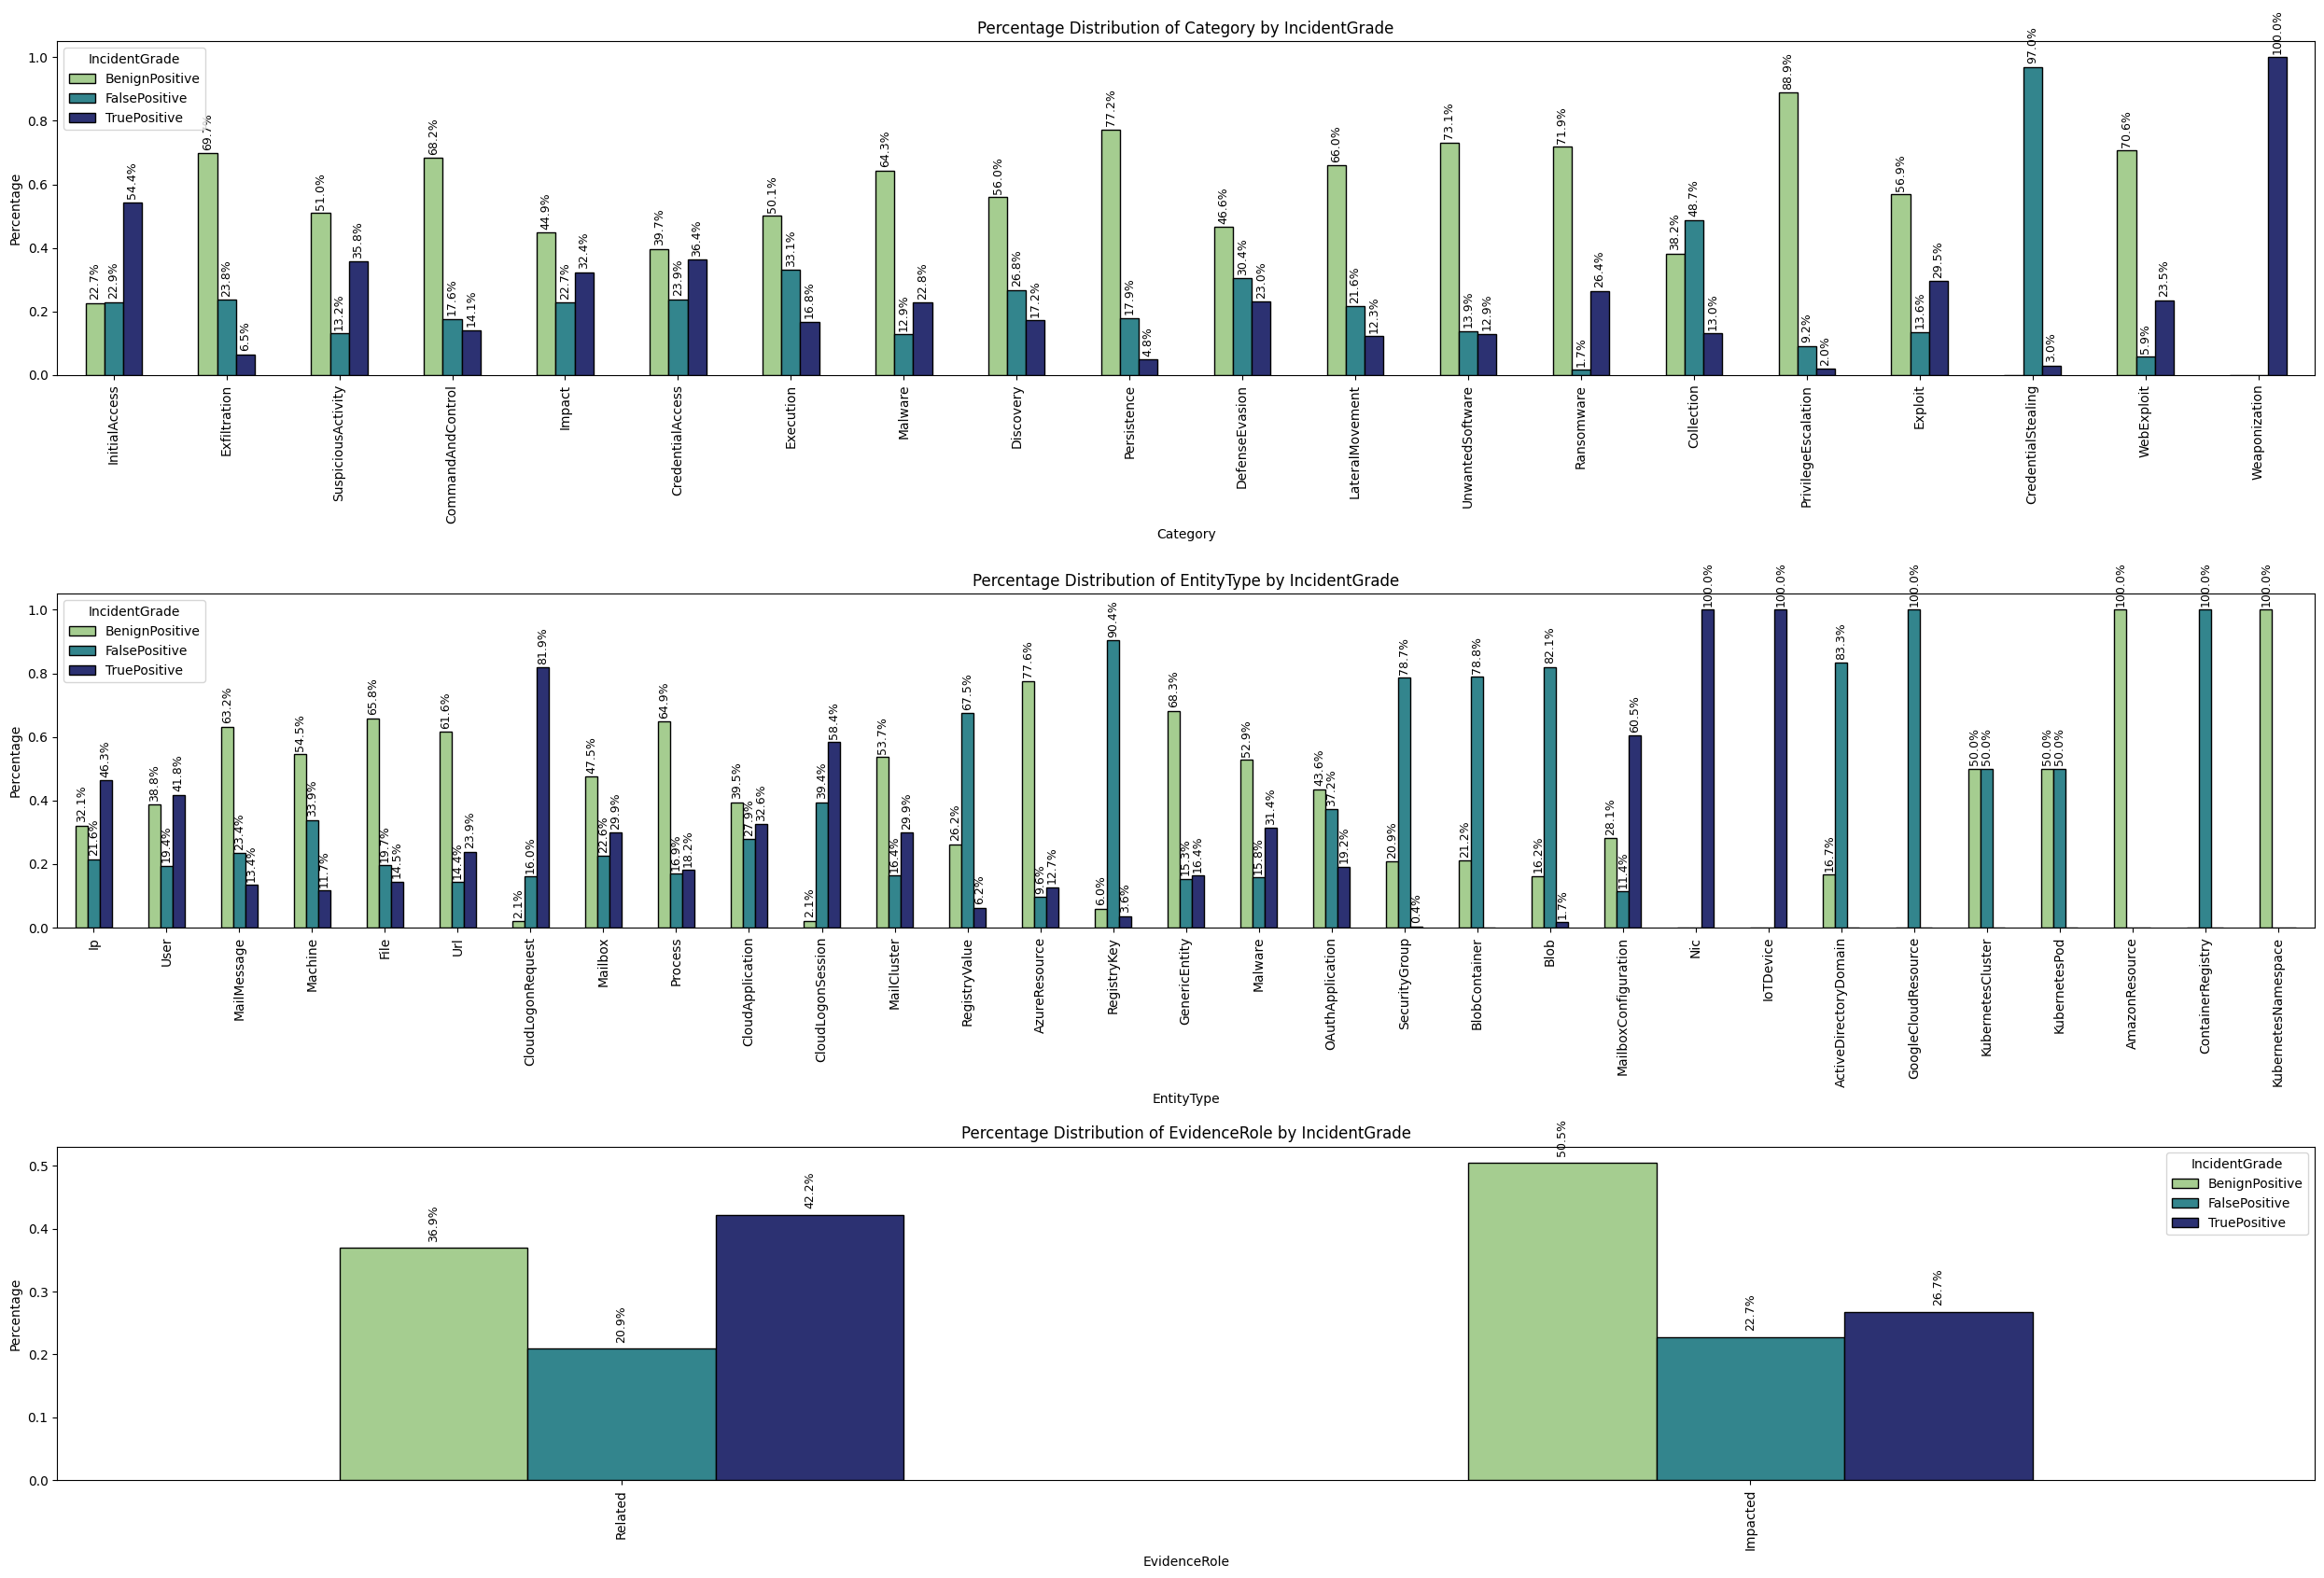

In [ ]:
cols_to_plot = [col for col in cat_features if col != 'IncidentGrade']
fig, axes = plt.subplots(3, 1, figsize=(25, 17))
axes = axes.flatten()

for idx, col in enumerate(cols_to_plot): 
    cross_tab = pd.crosstab(clean_df[col], clean_df['IncidentGrade'], normalize='index')
    order = clean_df[col].value_counts().index
    cross_tab = cross_tab.loc[order]

    ax = cross_tab.plot(kind='bar', ax=axes[idx], cmap='crest', edgecolor='black', legend=True)

    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height * 100:.1f}%', ha='center', va='bottom', fontsize=9, rotation=90)

    ax.set_title(f'Percentage Distribution of {col} by IncidentGrade')
    ax.set_xlabel(col)
    ax.set_ylabel('Percentage')
    ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

##### Distribution of CATEGORY
- There are 20 unique categories of alerts with most incidents occuring in the top 5 categories being IntialAccess, Exfiltration, SuspiciousActivity, CommandAndControl & Impact. 
- The other incidents occur in the rest of the 15 categories but they are only 11.52% of the incidents.

##### Distribution of ENTITYTYPE
- There are 31 different types of entites with almost 45% of alerts coming from Ip & User entity types.
- The top 5 entity types ip, User, MailMessage, Machine & File contribute to more than 70% incidents & the rest 26 entity types contributing to almost 30% of incidents

##### Distribution of EVIDENCEROLE
- EvidenceRole has only 2 unique vaules with Related (54.42%) being the most occuring EvidenceRole in incidents followed by Impacted (45.58%) 

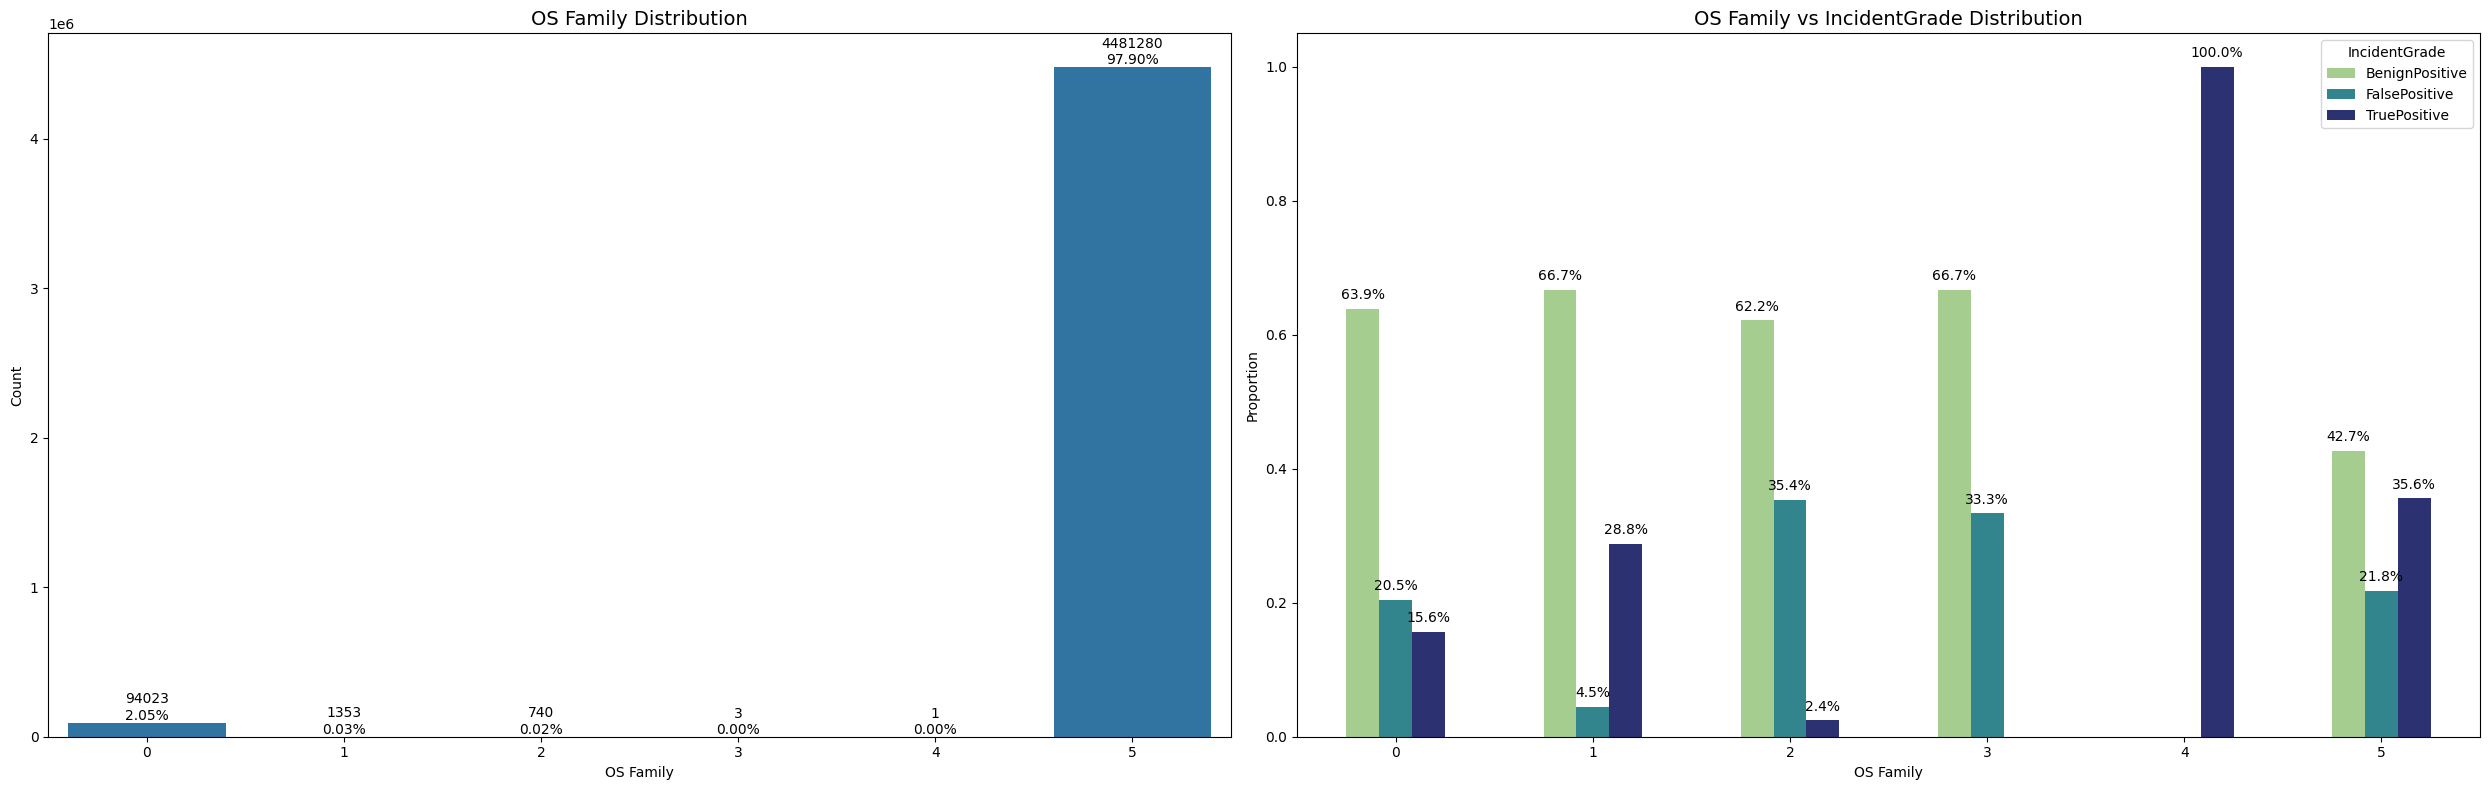

In [ ]:
# OS Family analysis
if 'OSFamily' in clean_df.columns:
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))
    sns.countplot(data=clean_df, x='OSFamily', ax=ax[0])

    total = len(clean_df['OSFamily'])
    for p in ax[0].patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax[0].annotate(f'{count}\n{percentage:.2f}%', (p.get_x() + p.get_width() / 2., count), ha='center', va='bottom', fontsize=10)
        
    ax[0].set_title('OS Family Distribution', fontsize=14)
    ax[0].set_xlabel('OS Family')
    ax[0].set_ylabel('Count')
    
    # OS Family vs Incident Grade 
    os_grade = pd.crosstab(clean_df['OSFamily'], clean_df['IncidentGrade'], normalize='index')
    os_grade.plot(kind='bar', cmap='crest', ax=ax[1])

    for container in ax[1].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax[1].text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height * 100:.1f}%', ha='center',va='bottom', fontsize=10)

    ax[1].set_title('OS Family vs IncidentGrade Distribution', fontsize=14)
    ax[1].set_xlabel('OS Family')
    ax[1].set_ylabel('Proportion')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# OSFamily 5 Analysis
if 'OSFamily' in clean_df.columns and 'OSVersion' in clean_df.columns:
    osf_5 = clean_df[clean_df['OSFamily'] == 5]
    print(f"No. of OSVersions in OSFamily 5: {osf_5['OSVersion'].nunique()}")

    counts = osf_5['OSVersion'].value_counts()
    percentages = (counts / counts.sum()) * 100

    osf_5_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    display(osf_5_df)

No. of OSVersions in OSFamily 5: 1


,Count,Percentage
OSVersion,,
66,4481280,100.0


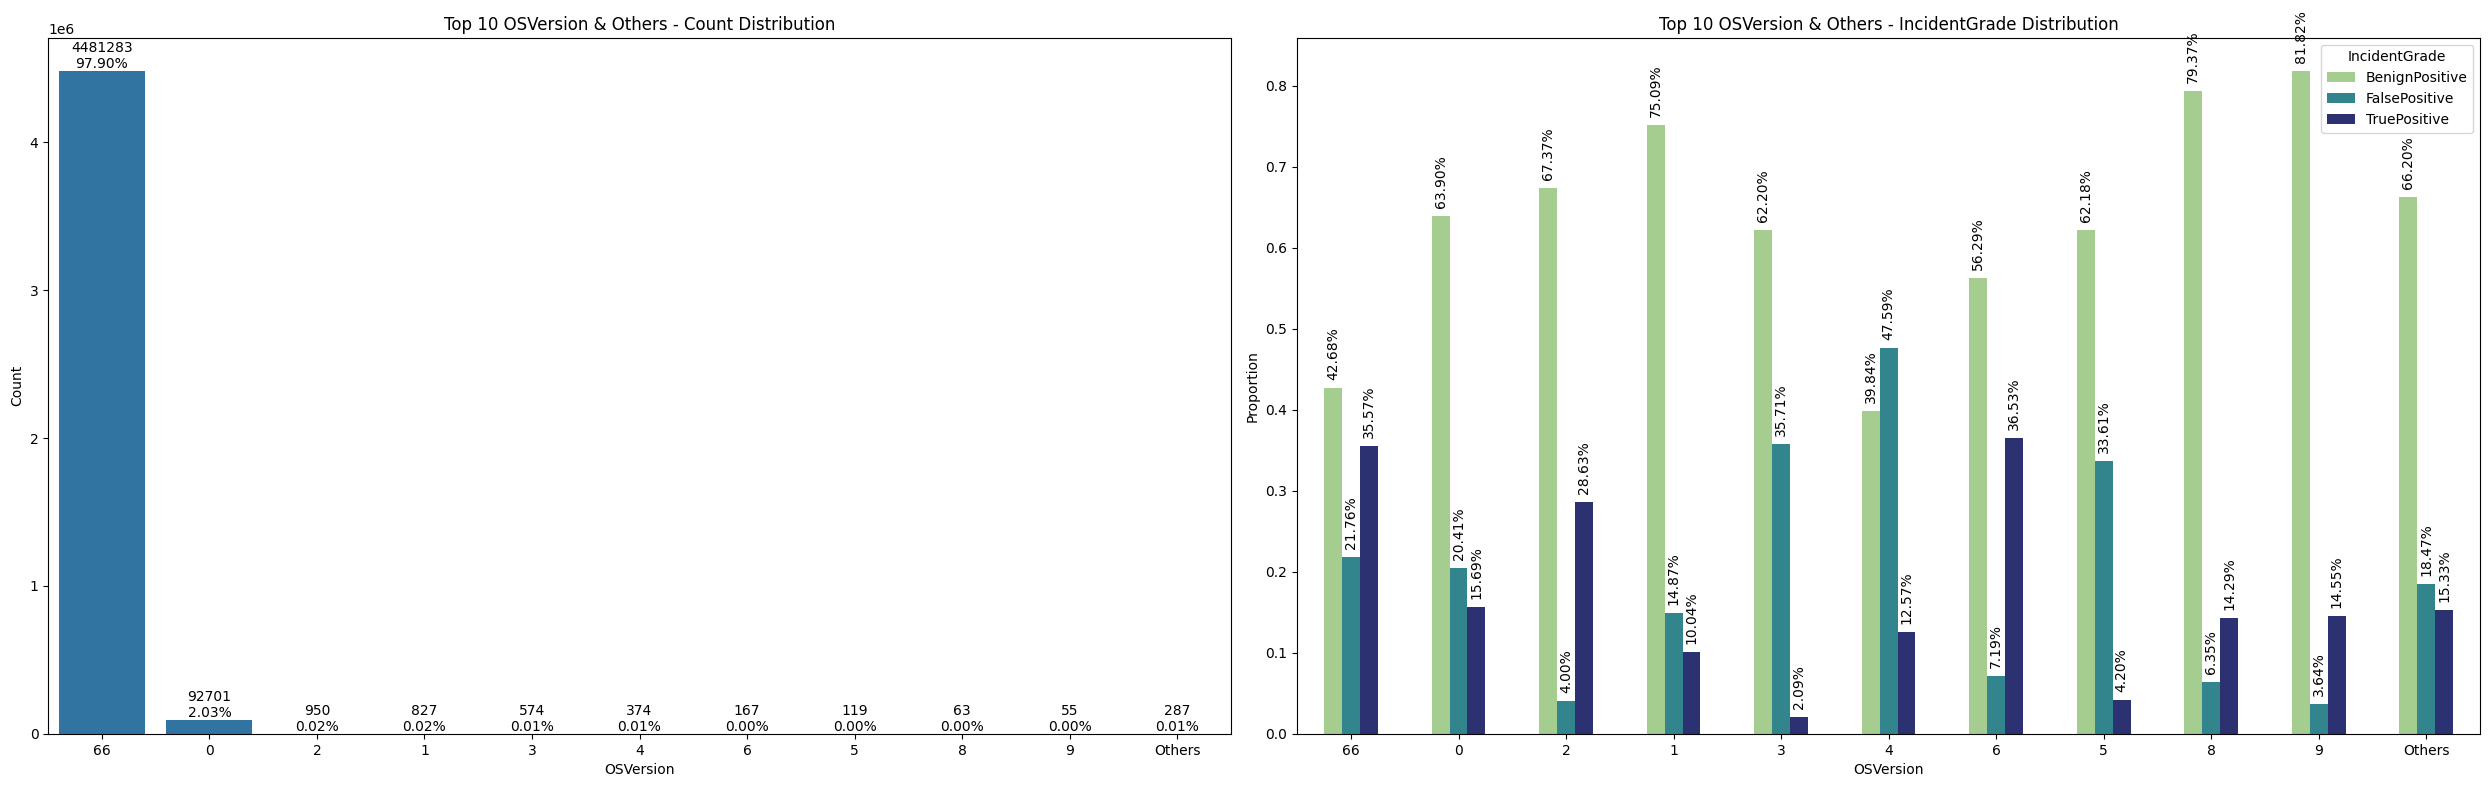

In [ ]:
# OSVersion analysis
if 'OSVersion' in clean_df.columns:

    value_counts = clean_df['OSVersion'].value_counts()
    top_os_versions = value_counts.nlargest(10).index.tolist()
    plot_order = top_os_versions + ['Others']
    mapped_osv = clean_df['OSVersion'].apply(lambda x: x if x in top_os_versions else 'Others')

    filtered_df = clean_df.copy()
    filtered_df['Mappedosv'] = mapped_osv
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    # Count Plot 
    sns.countplot(data=filtered_df, x='Mappedosv', order=plot_order, ax=ax[0], legend=False)

    total = len(filtered_df)
    for p in ax[0].patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax[0].annotate(f'{count}\n{percentage:.2f}%', (p.get_x() + p.get_width() / 2., count), ha='center', va='bottom', fontsize=10)

    ax[0].set_title('Top 10 OSVersion & Others - Count Distribution')
    ax[0].set_xlabel('OSVersion')
    ax[0].set_ylabel('Count')

    # IncidentGrade Distribution Plot
    osv_ct = pd.crosstab(filtered_df['Mappedosv'],  filtered_df['IncidentGrade'],  normalize='index')
    osv_ct = osv_ct.loc[plot_order]
    osv_ct.plot(kind='bar', ax=ax[1], cmap='crest')

    for container in ax[1].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height + 0.01, f'{height * 100:.2f}%', ha='center', va='bottom', fontsize=10, rotation=90)

    ax[1].set_title('Top 10 OSVersion & Others - IncidentGrade Distribution')
    ax[1].set_xlabel('OSVersion')
    ax[1].set_ylabel('Proportion')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

##### **Distribution of OSFAMILY & OSVERSION**

***OSFamily***
- OSFamily distribution shows that almost 98% of the incidents occur in OSFamily 5 showing that most of attacks are focused on OSFamily 5 due to its dominance & it having a consistent OSVersion 66
- A significant portion of alerts on OS Family 5 are True Positives (35.6%), indicating real security incidents, but also a noteworthy number of False Positives (21.8%) 

***OSVersion***
- OSVersion 66 has almost 98% of incidents, all the other OSVersions just contribute close to 2.5% of incidents.
- All the other OSVersions except OSVersion 66 have > 50% of incidents as BP.
- In contrast, OSVersion 66 accounts for a significantly higher rate of TP/FP, suggesting it may represent higher operational risk, detection sensitivity, or adversarial targeting.

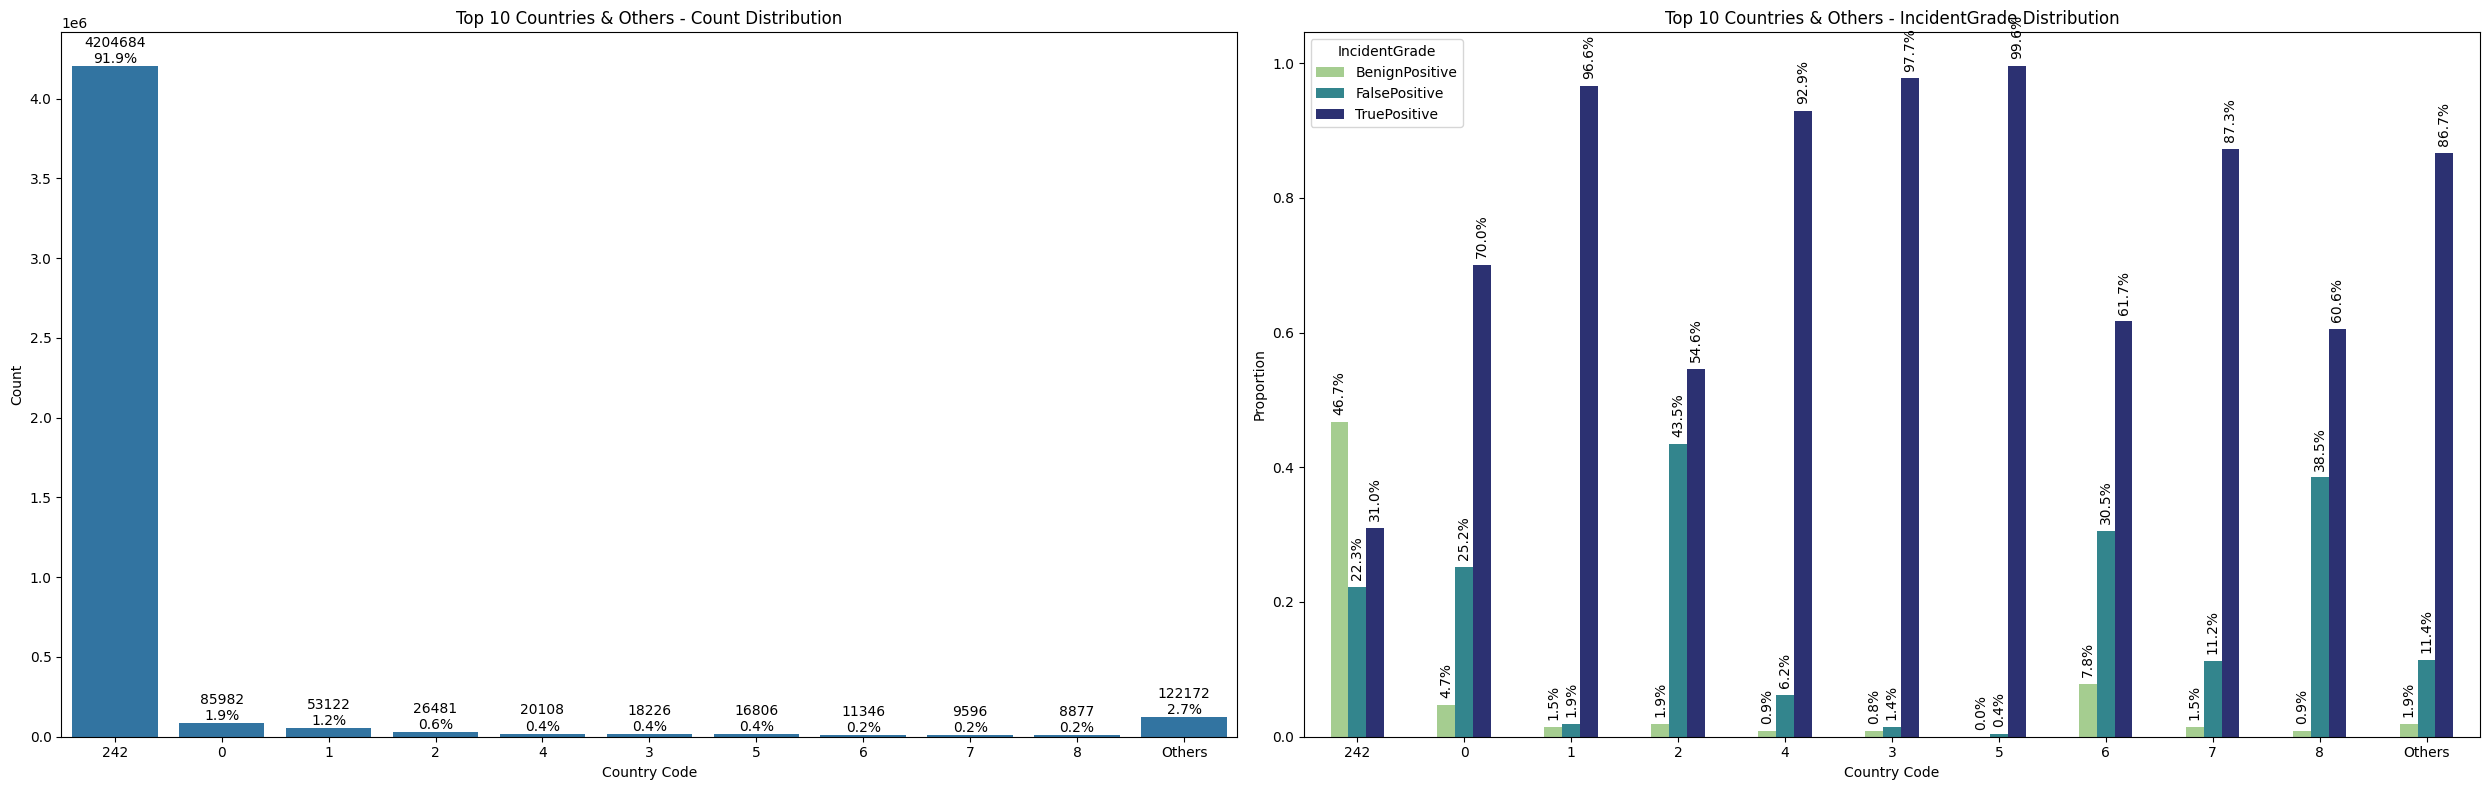

In [ ]:
# Country analysis
if 'CountryCode' in clean_df.columns:

    value_counts = clean_df['CountryCode'].value_counts()
    top_country_codes = value_counts.nlargest(10).index.tolist()
    plot_order = top_country_codes + ['Others']
    mapped_country = clean_df['CountryCode'].apply(lambda x: x if x in top_country_codes else 'Others')

    filtered_df = clean_df.copy()
    filtered_df['MappedCountry'] = mapped_country
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    # Count Plot 
    sns.countplot(data=filtered_df, x='MappedCountry', order=plot_order, ax=ax[0], legend=False)

    total = len(filtered_df)
    for p in ax[0].patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax[0].annotate(f'{count}\n{percentage:.1f}%', (p.get_x() + p.get_width() / 2., count), ha='center', va='bottom', fontsize=10)

    ax[0].set_title('Top 10 Countries & Others - Count Distribution')
    ax[0].set_xlabel('Country Code')
    ax[0].set_ylabel('Count')

    # IncidentGrade Distribution Plot
    country_ct = pd.crosstab(filtered_df['MappedCountry'],  filtered_df['IncidentGrade'],  normalize='index')
    country_ct = country_ct.loc[plot_order]
    country_ct.plot(kind='bar', ax=ax[1], cmap='crest')

    for container in ax[1].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height + 0.01, f'{height * 100:.1f}%', ha='center', va='bottom', fontsize=10, rotation=90)

    ax[1].set_title('Top 10 Countries & Others - IncidentGrade Distribution')
    ax[1].set_xlabel('Country Code')
    ax[1].set_ylabel('Proportion')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# Country 242 Analysis
if 'CountryCode' in clean_df.columns and 'State' in clean_df.columns:
    country_242 = clean_df[clean_df['CountryCode'] == 242]
    print(f"No. of States in Country 242: {country_242['State'].nunique()}\n")

    counts = country_242['State'].value_counts()
    percentages = (counts / counts.sum()) * 100

    country_242_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    display(country_242_df.sort_index(ascending=True))

No. of States in Country 242: 4



,Count,Percentage
State,,
1,5,0.000119
12,1,0.000024
1268,1,0.000024
1445,4204677,99.999834


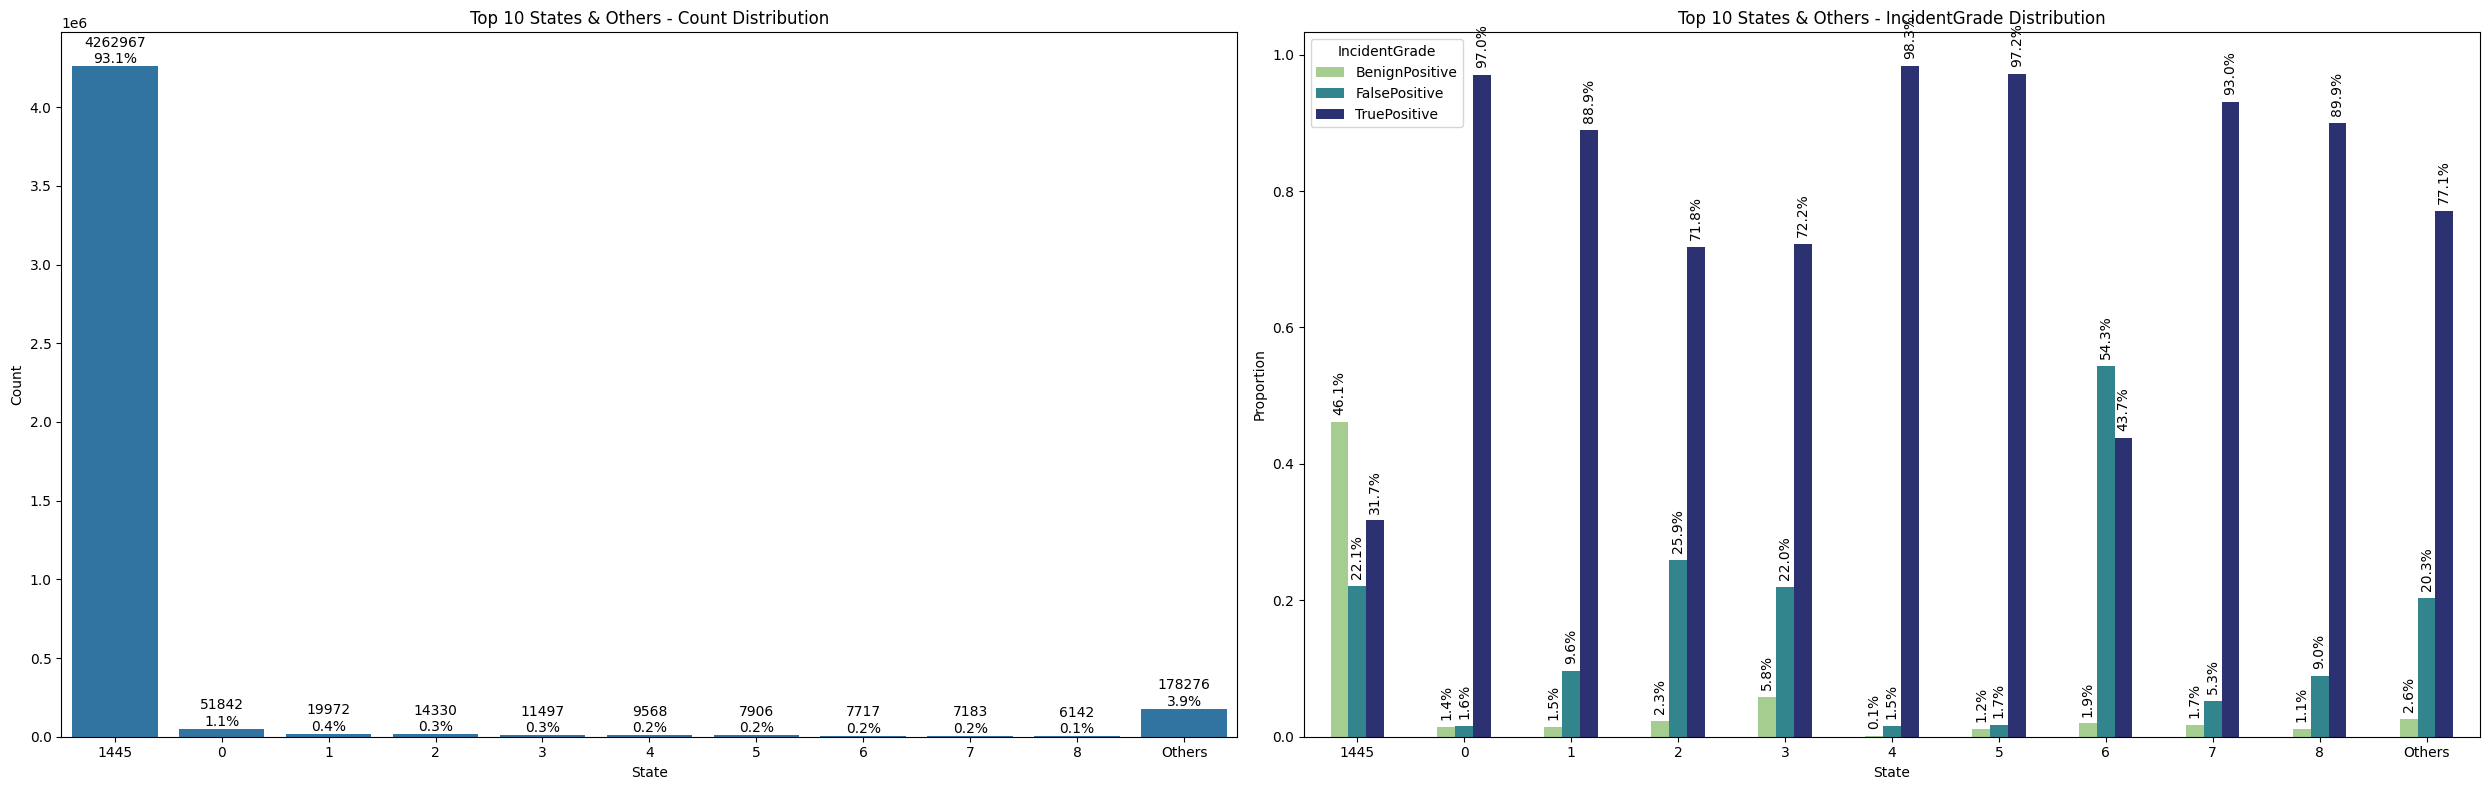

In [ ]:
# State analysis
if 'State' in clean_df.columns:

    value_counts = clean_df['State'].value_counts()
    top_states = value_counts.nlargest(10).index.tolist()
    plot_order = top_states + ['Others']
    mapped_state = clean_df['State'].apply(lambda x: x if x in top_states else 'Others')

    filtered_df = clean_df.copy()
    filtered_df['Mappedstate'] = mapped_state
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    # Count Plot 
    sns.countplot(data=filtered_df, x='Mappedstate', order=plot_order, ax=ax[0], legend=False)

    total = len(filtered_df)
    for p in ax[0].patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax[0].annotate(f'{count}\n{percentage:.1f}%', (p.get_x() + p.get_width() / 2., count), ha='center', va='bottom', fontsize=10)

    ax[0].set_title('Top 10 States & Others - Count Distribution')
    ax[0].set_xlabel('State')
    ax[0].set_ylabel('Count')

    # IncidentGrade Distribution Plot
    state_ct = pd.crosstab(filtered_df['Mappedstate'],  filtered_df['IncidentGrade'],  normalize='index')
    state_ct = state_ct.loc[plot_order]
    state_ct.plot(kind='bar', ax=ax[1], cmap='crest')

    for container in ax[1].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height + 0.01, f'{height * 100:.1f}%', ha='center', va='bottom', fontsize=10, rotation=90)

    ax[1].set_title('Top 10 States & Others - IncidentGrade Distribution')
    ax[1].set_xlabel('State')
    ax[1].set_ylabel('Proportion')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
# State 1445 Analysis
if 'State' in clean_df.columns and 'City' in clean_df.columns:
    state_1445 = clean_df[clean_df['State'] == 1445]
    print(f"No. of Cities in State 1445: {state_1445['City'].nunique()}")

    counts = state_1445['City'].value_counts()
    percentages = (counts / counts.sum()) * 100

    state_1445_df = pd.DataFrame({'Count': counts, 'Percentage': percentages})
    display(state_1445_df.sort_values(by='Percentage', ascending=False).head())

No. of Cities in State 1445: 29


,Count,Percentage
City,,
10630,4262648,99.992517
3,172,0.004035
314,52,0.001220
379,20,0.000469
827,16,0.000375


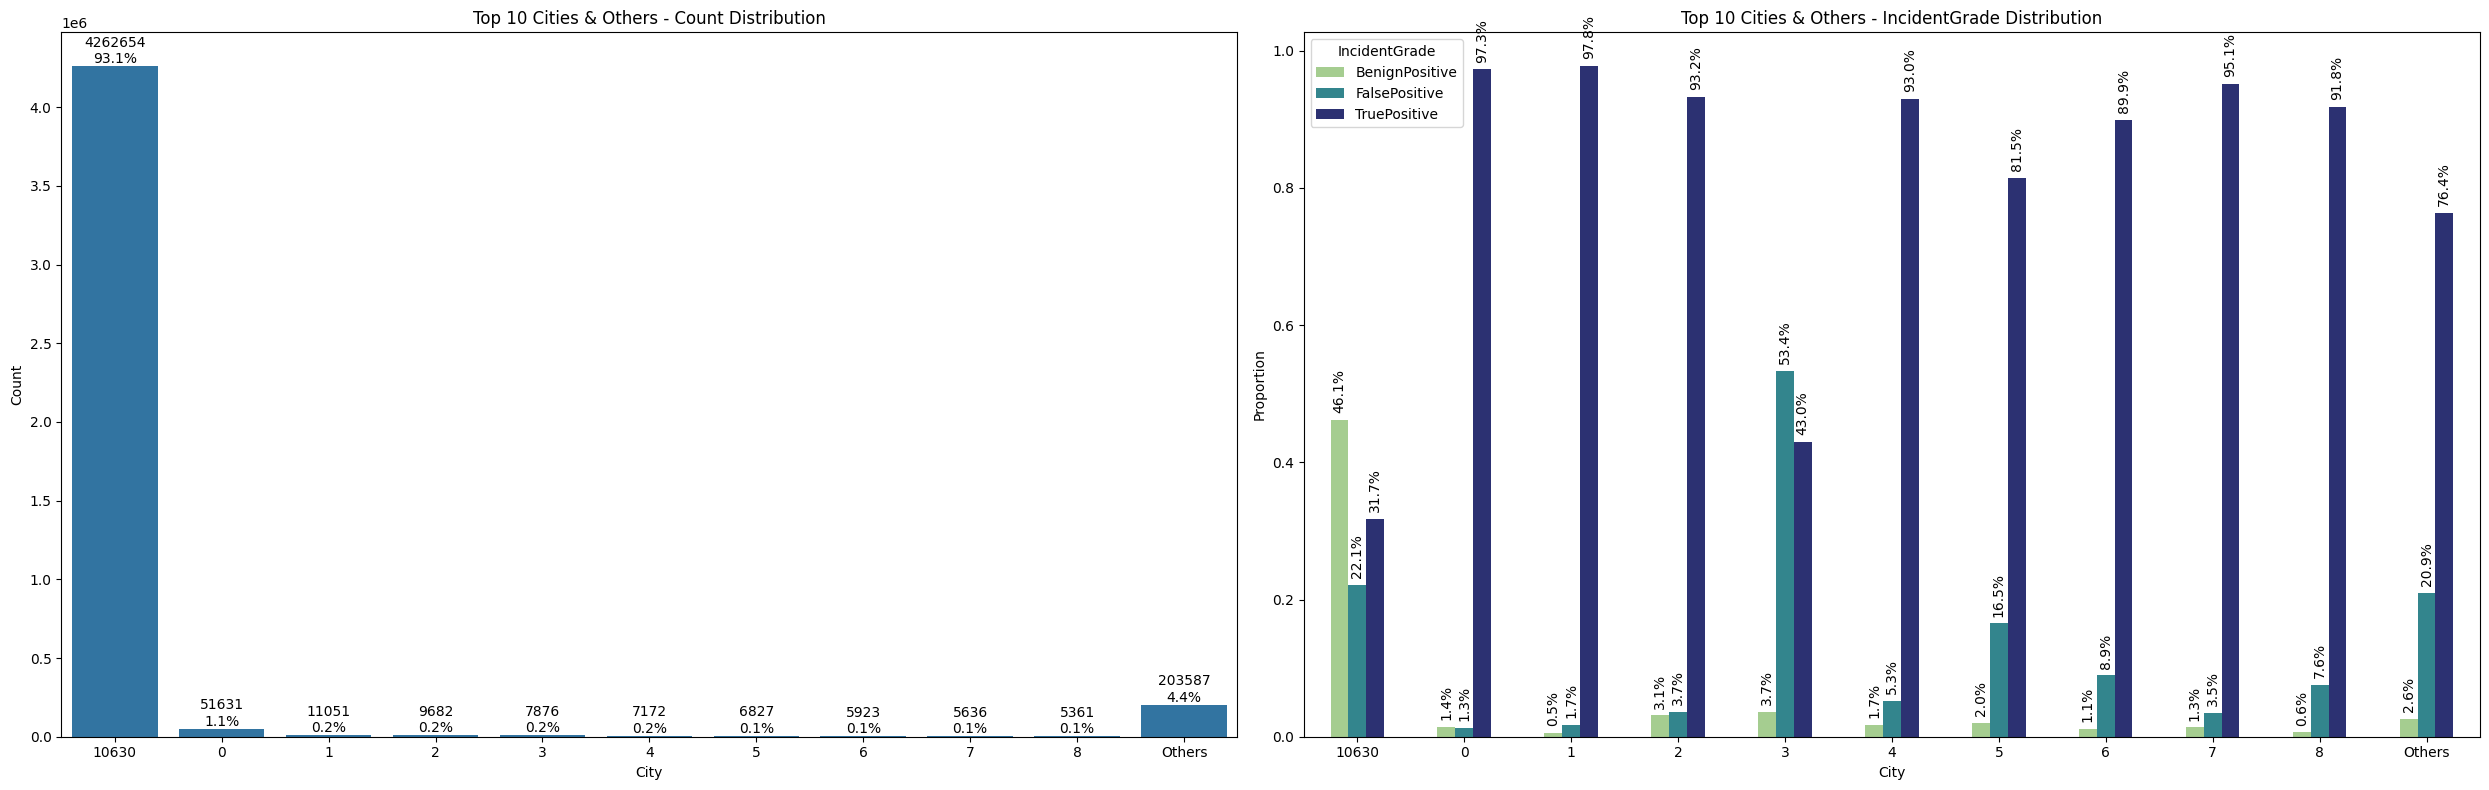

In [ ]:
# City analysis
if 'City' in clean_df.columns:

    value_counts = clean_df['City'].value_counts()
    top_cities = value_counts.nlargest(10).index.tolist()
    plot_order = top_cities + ['Others']
    mapped_city = clean_df['City'].apply(lambda x: x if x in top_cities else 'Others')

    filtered_df = clean_df.copy()
    filtered_df['Mappedcity'] = mapped_city
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    # Count Plot 
    sns.countplot(data=filtered_df, x='Mappedcity', order=plot_order, ax=ax[0], legend=False)

    total = len(filtered_df)
    for p in ax[0].patches:
        count = int(p.get_height())
        percentage = 100 * count / total
        ax[0].annotate(f'{count}\n{percentage:.1f}%', (p.get_x() + p.get_width() / 2., count), ha='center', va='bottom', fontsize=10)

    ax[0].set_title('Top 10 Cities & Others - Count Distribution')
    ax[0].set_xlabel('City')
    ax[0].set_ylabel('Count')

    # IncidentGrade Distribution Plot
    city_ct = pd.crosstab(filtered_df['Mappedcity'],  filtered_df['IncidentGrade'],  normalize='index')
    city_ct = city_ct.loc[plot_order]
    city_ct.plot(kind='bar', ax=ax[1], cmap='crest')

    for container in ax[1].containers:
        for bar in container:
            height = bar.get_height()
            if height > 0:
                ax[1].text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height + 0.01, f'{height * 100:.1f}%', ha='center', va='bottom', fontsize=10, rotation=90)

    ax[1].set_title('Top 10 Cities & Others - IncidentGrade Distribution')
    ax[1].set_xlabel('City')
    ax[1].set_ylabel('Proportion')

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

#### **GEOGRAPHICAL ANALYSIS [The data is heavily concentrated in a single country (242), single state (1445), and single city (10630)]**
***COUNTRY*** 
- CountryCode has 212 unique values but CountryCode 242 dominates with 4.2 million incidents (91.9%)
- All other top 9 countries combined account for just 5.5%, & all other countries account for just 2.7% of incidents, indicating extreme data skewness.
- Country 242 has a diverse mix of incident grades: ***BenignPositive: 46.7%, FalsePositive: 22.3%, TruePositive: 31.0%***
- There are 4 states in Country 242 with State 1445 is the major contributor, >99% of Country 242’s data comes from this one state.
  
***STATE***
- State has 1197 unique values with State 1445 dominating the dataset with 4.26 million incidents (93.1%)
- The remaining top 9 states contribute to only 3% while the other states contribute to 3.9% of incidents. 
- State 1445 is the major contributor: ***BenignPositive: 46.1%, FalsePositive: 22.1%, TruePositive: 31.7%***
- All the other states mostly have >90% TruePositives, indicating cleaner/more accurate detections.
- State 1445 have 29 cities with only 1 city contributing up to ~99.99% of the state’s incidents

***CITY***
- City has 7107 unique values with City 10630 dominating the dataset with 4.26 million incidents (93.1%)
- The other top 9 cities contributing to just 2.3% & other cities individually contribute negligible percentages while combiningly contribute to 4.4% of incidents.
- City 10630 dominates within State 1445: ***BenignPositive: 46.1%, FalsePositive: 22.1%, TruePositive: 31.7%*** making up ~99.99% of the state’s incidents.

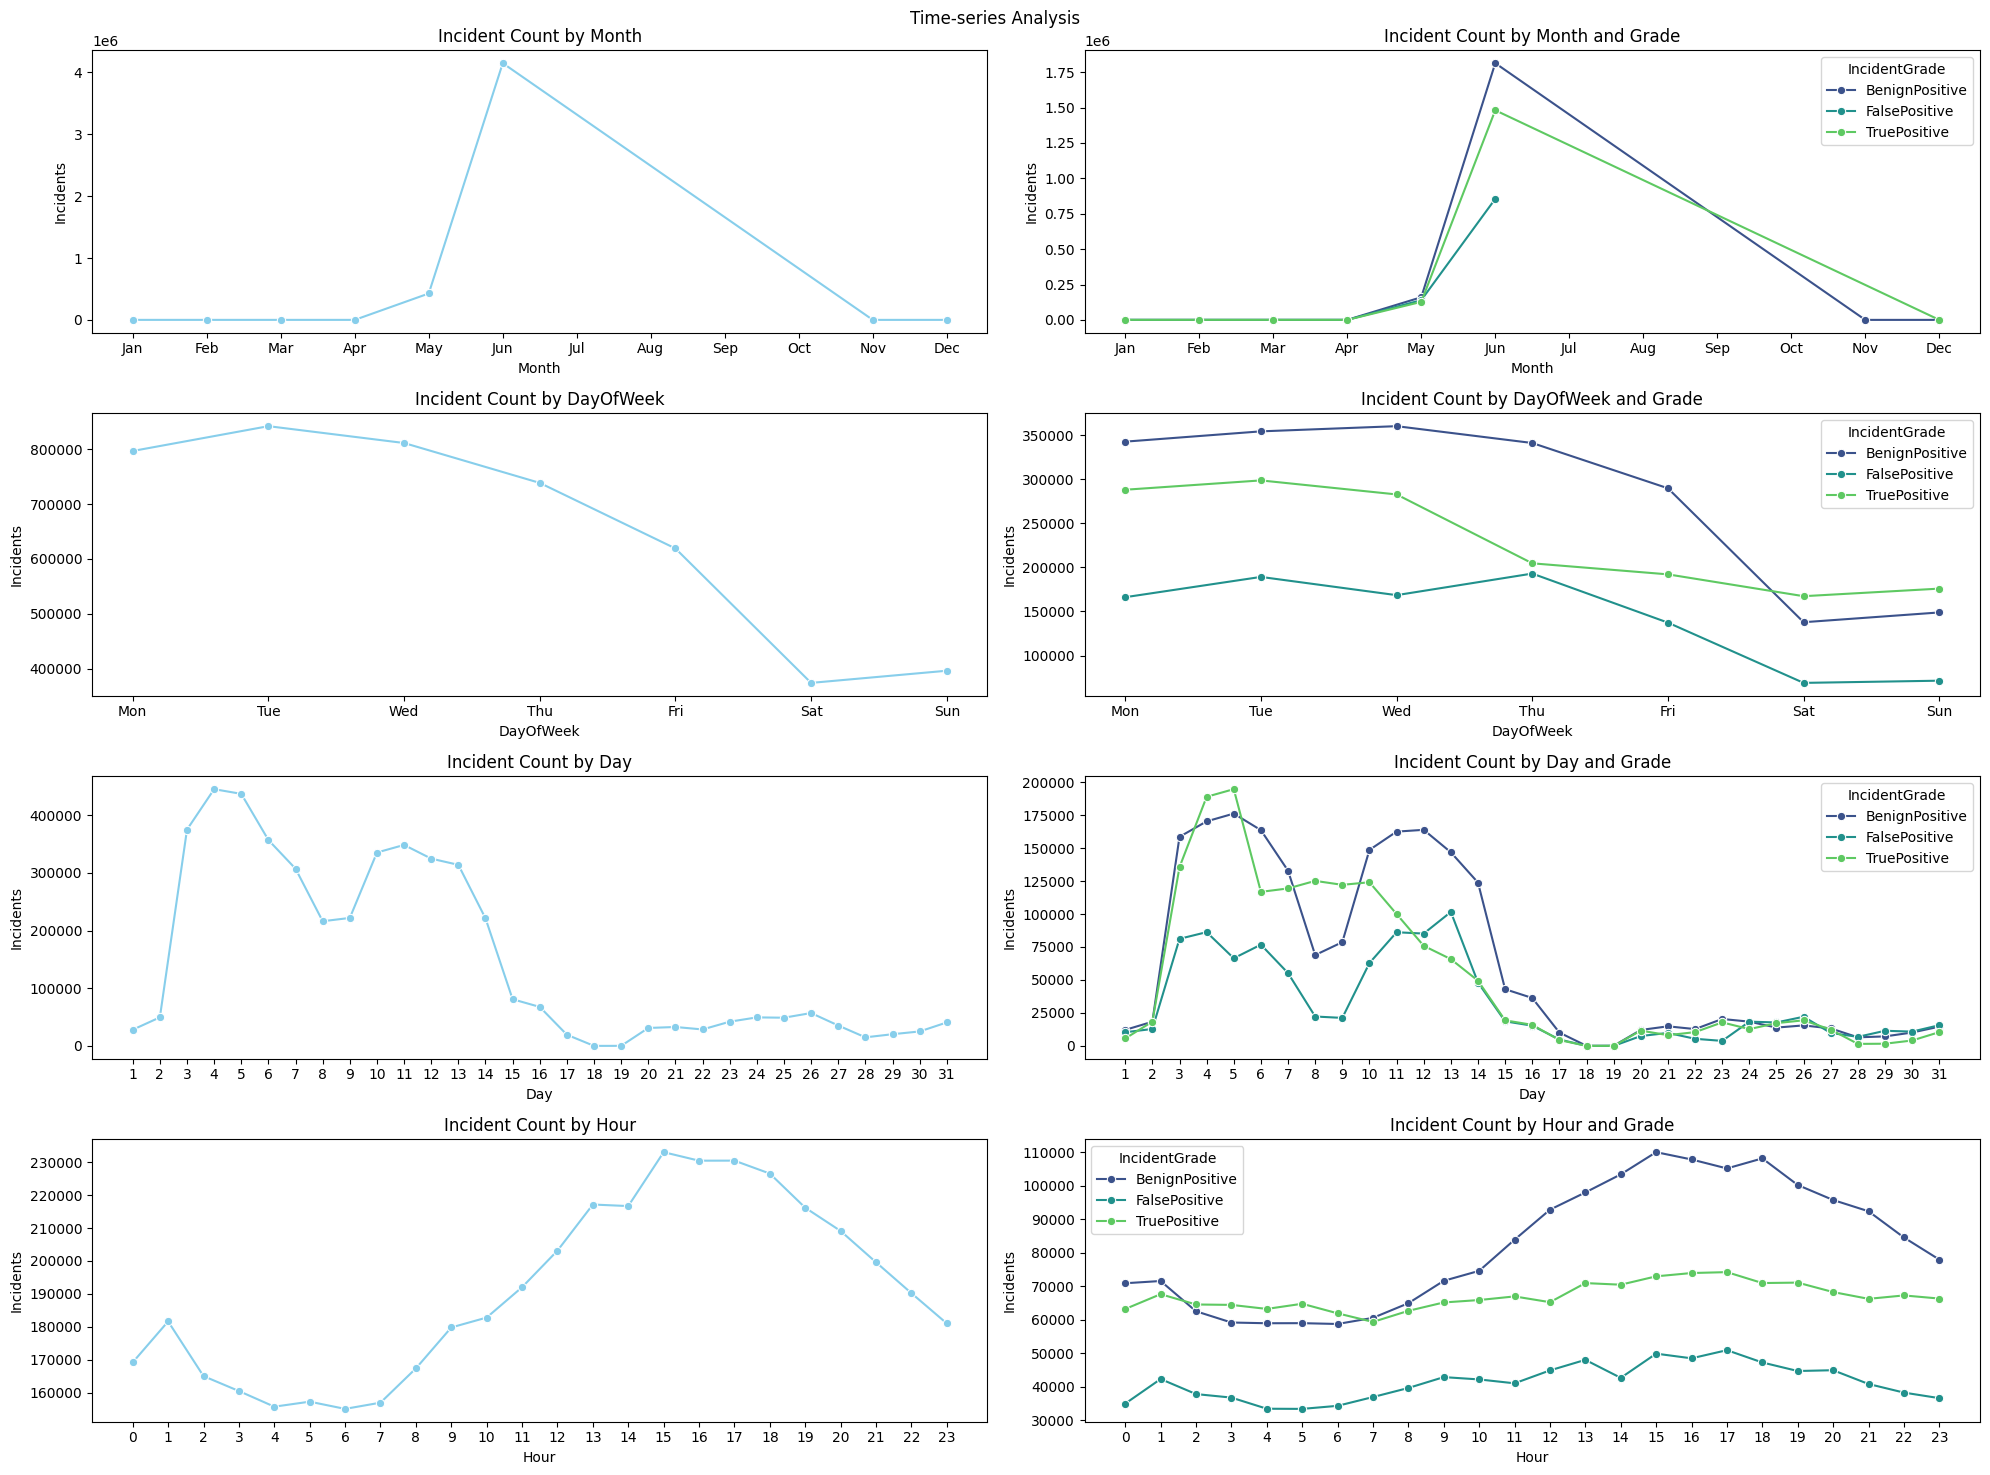

In [ ]:
# TIME-SERIES ANALYSIS
def plot_time_series(ax1, ax2, df, col, label_map=None):

    # Plot total count
    counts = df[col].value_counts().sort_index()
    sns.lineplot(ax=ax1, x=counts.index, y=counts.values, marker='o', color='skyblue')
    ax1.set_title(f'Incident Count by {col}')
    ax1.set_xlabel(col)
    ax1.set_ylabel('Incidents')
    if label_map:
        ax1.set_xticks(list(label_map.keys()))
        ax1.set_xticklabels(list(label_map.values()))
    else:
        ax1.set_xticks(sorted(df[col].unique()))

    # Plot count by IncidentGrade
    grouped = df.groupby([col, 'IncidentGrade']).size().reset_index(name='Count')
    sns.lineplot(ax=ax2, data=grouped, x=col, y='Count', hue='IncidentGrade', marker='o', palette='viridis')
    ax2.set_title(f'Incident Count by {col} and Grade')
    ax2.set_xlabel(col)
    ax2.set_ylabel('Incidents')
    if label_map:
        ax2.set_xticks(list(label_map.keys()))
        ax2.set_xticklabels(list(label_map.values()))
    else:
        ax2.set_xticks(sorted(df[col].unique()))

def analyze_temporal_patterns(df):
    fig, axes = plt.subplots(4, 2, figsize=(20, 15))
    plt.suptitle("Time-series Analysis")
    axes = axes.flatten()

    label_maps = {
        'DayOfWeek': {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'},
        'Month': {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    }

    time_columns = ['Month', 'DayOfWeek', 'Day', 'Hour']

    for i, col in enumerate(time_columns):
        label_map = label_maps.get(col)
        plot_time_series(axes[2*i], axes[2*i+1], df, col, label_map)

    plt.tight_layout()
    plt.show()

analyze_temporal_patterns(clean_df)

##### **TIME-SERIES ANALYSIS**
***Monthly Patterns***
- The monthly analysis reveals a highly concentrated incident pattern with a dramatic spike in June , while most other months minimal activity. 
- This suggests either a seasonal phenomenon or a specific event/period that drives incident occurrence.

***Weekly Patterns***
- Monday-Wednesday: High incident volumes (800K+ incidents), with Monday being the peak
- Thursday-Sunday: Significant decline, with weekends showing the lowest activity (~400K incidents)
- This pattern suggests incidents are strongly correlated with business/work cycles

***Daily Patterns (Day of Month)***
- The daily distribution shows extreme volatility in the 1st half of the month:
- Days 1-14: Very high incident counts with dramatic fluctuations (peaks reaching 400K+)
- Days 15-31: Relatively stable and much lower incident levels

***Hourly Patterns***
- Peak hours: 14-18 (2 PM - 6 PM), reaching 230K+ incidents
- Low hours: 3-7 (3 AM - 7 AM), dropping to ~155K incidents
- This aligns with typical business hours and user activity patterns

***Incident Grade Analysis***
- Across all temporal dimensions, the data shows three distinct incident grades:
- BenignPositive (blue): Generally shows the highest volumes
- TruePositive (green): Moderate volumes, often following similar patterns to BenignPositive
- FalsePositive (teal): Consistently lower volumes across all time periods

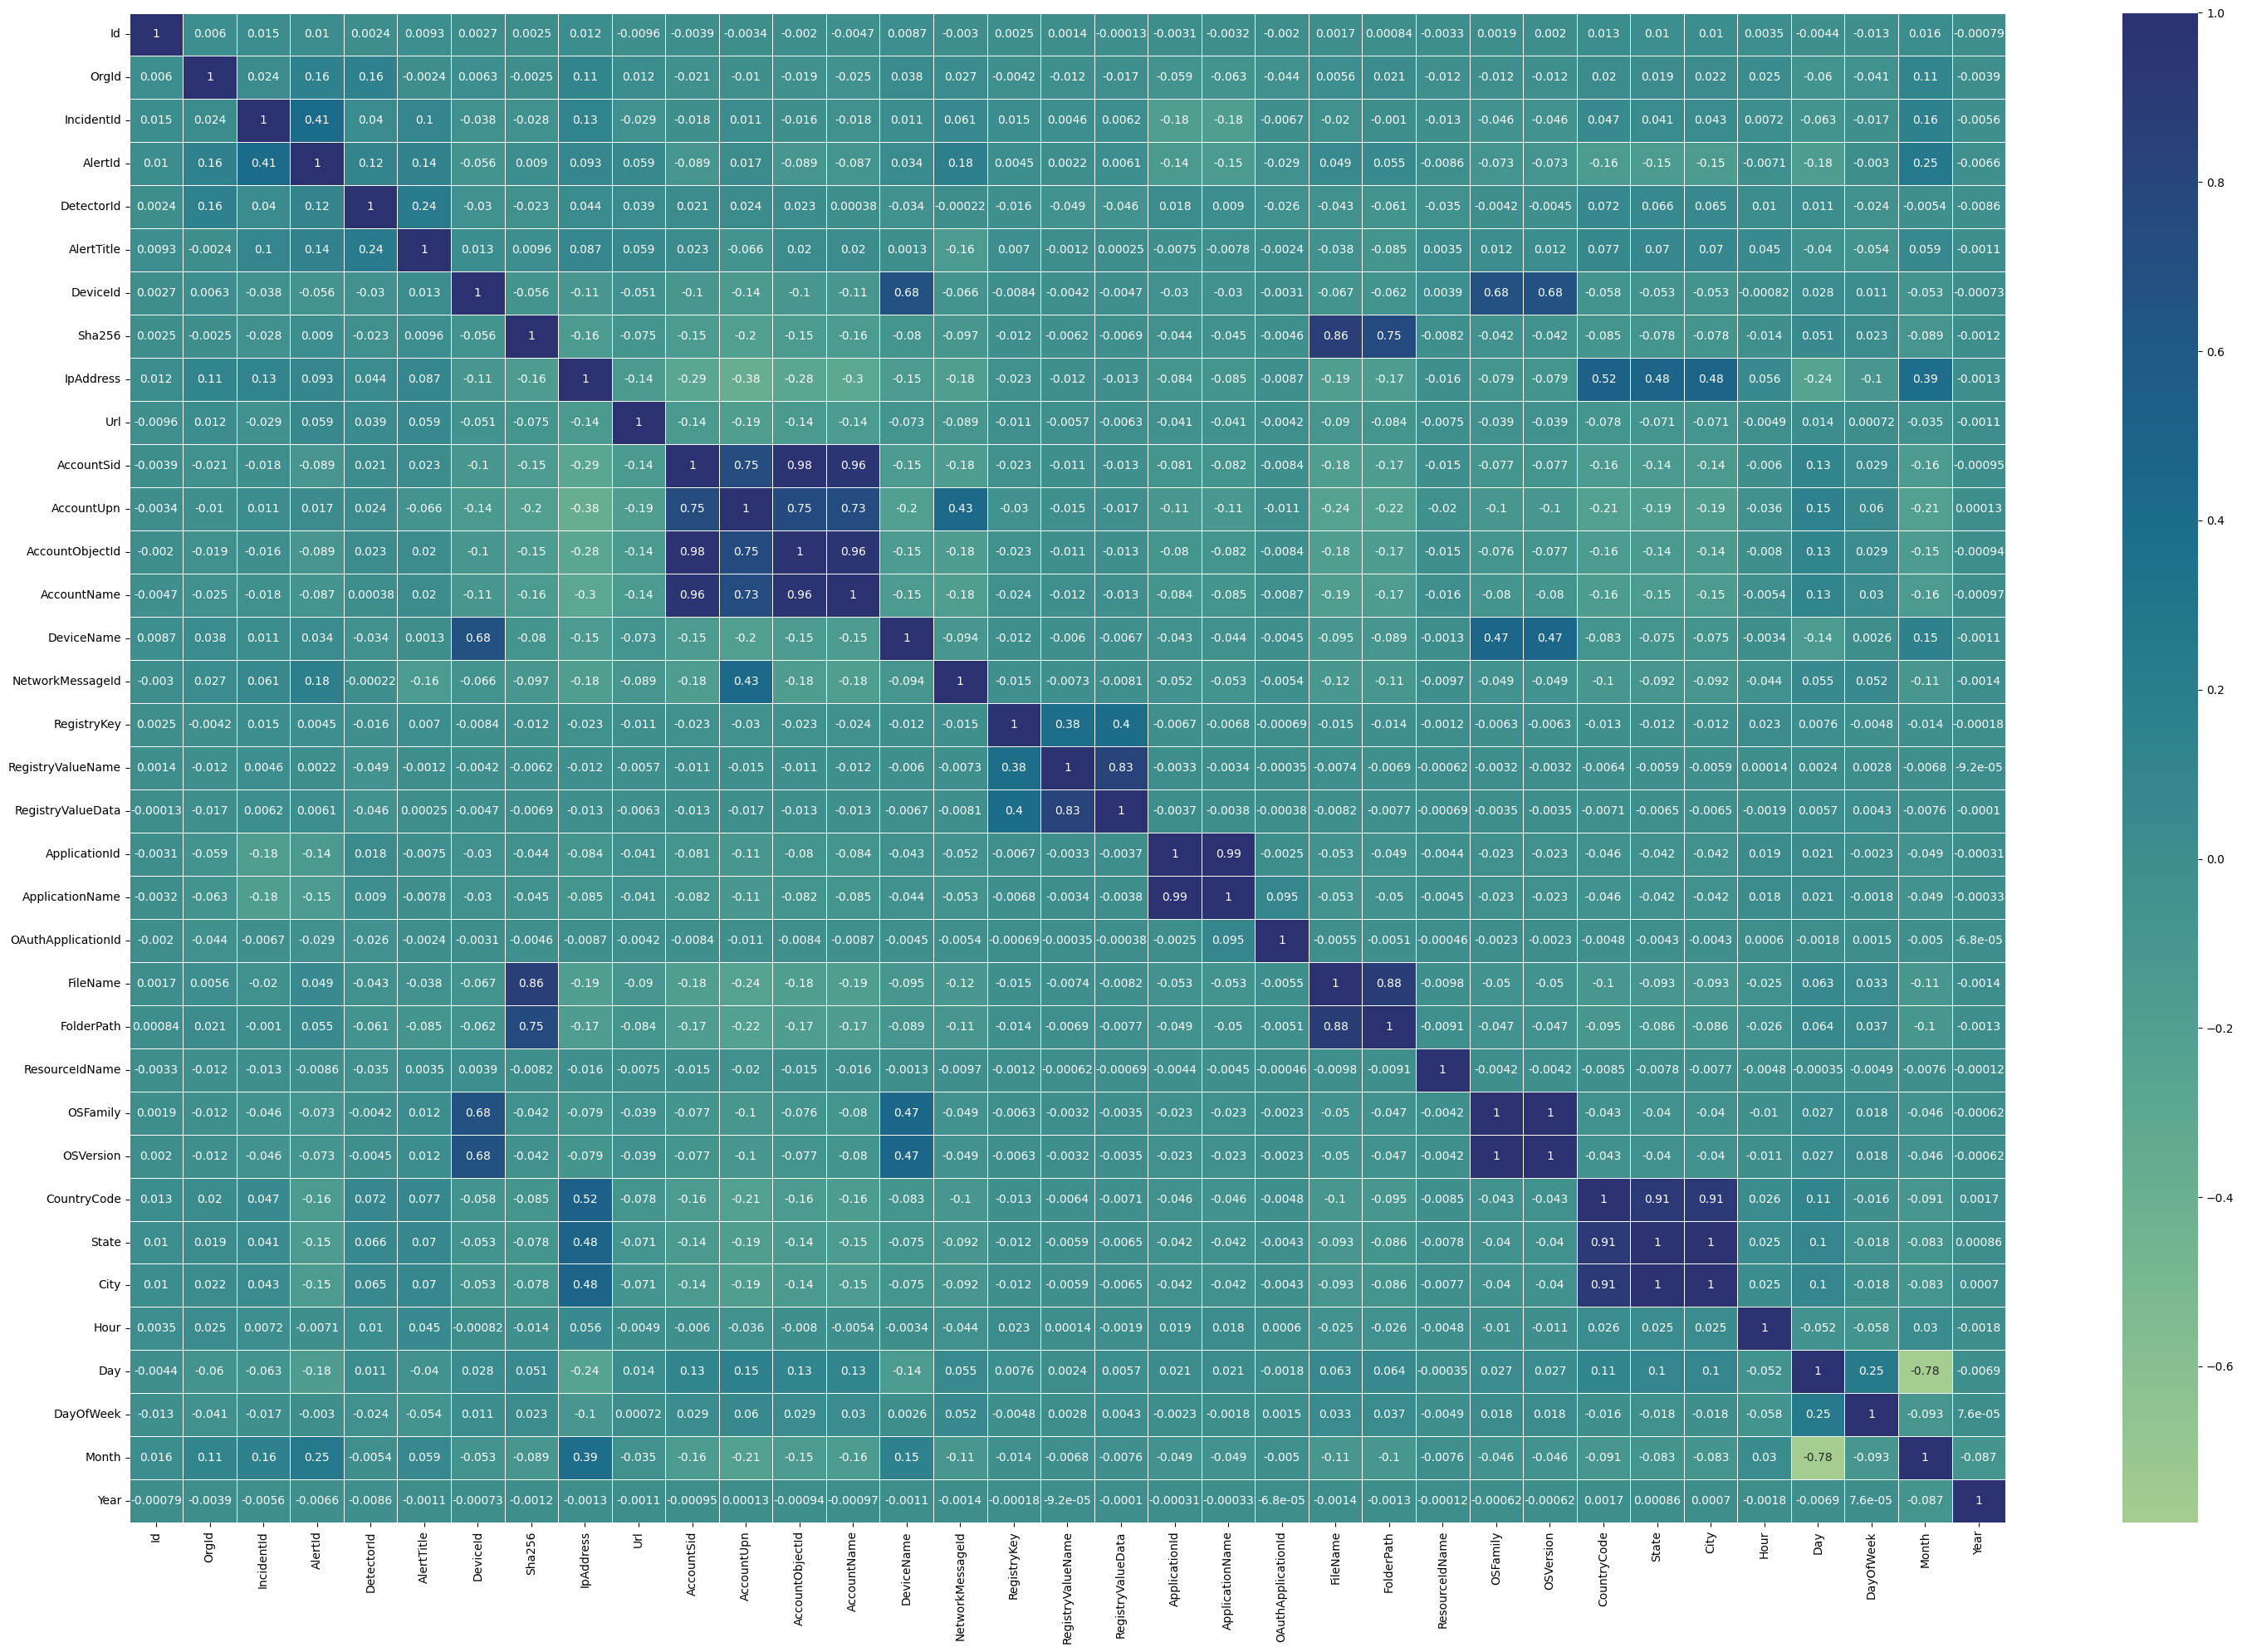

In [ ]:
plt.figure(figsize = (30, 20))
sns.heatmap(clean_df[num_features].corr(), cmap = 'crest', annot = True, linewidth = 0.5)
plt.tight_layout()  
plt.show()

**Highly Correlated Features (Multicollinearity)**

**Features with correlation ≥ 0.8 are redundant, so we should keep only one from each pair.**

- AccountObjectId (0.98) and AccountSid (0.75) & AccountUpn (0.75) → Dropping AccountSid & AccountUpn
- FileName (0.86) and Sha256 → Dropping Sha256 
- FolderPath (0.75) and FileName → Dropping FolderPath 
- RegistryValueName (0.83) and RegistryValueData → Dropping RegistryValueName.
- ApplicationId (0.99) and ApplicationName → Dropping ApplicationId.
- OSFamily (1.00) and OSVersion → Dropping OSFamily.
- (State, City (1.00)), and CountryCode (0.91) → Dropping Country and City.
  
**Low-Impact Features**

**These have near-zero correlation with other features, making them less informative.**

- OAuthApplicationId → Very low correlation, can be dropped.
- ResourceIdName → Low correlation, not very useful.
- RegistryKey → Low correlation, likely not impactful.

In [ ]:
clean_df

,Id,OrgId,IncidentId,AlertId,DetectorId,AlertTitle,Category,IncidentGrade,EntityType,EvidenceRole,DeviceId,Sha256,IpAddress,Url,AccountSid,AccountUpn,AccountObjectId,AccountName,DeviceName,NetworkMessageId,RegistryKey,RegistryValueName,RegistryValueData,ApplicationId,ApplicationName,OAuthApplicationId,FileName,FolderPath,ResourceIdName,OSFamily,OSVersion,CountryCode,State,City,Hour,Day,DayOfWeek,Month,Year
0,1709396985476,26,18583,687462,31,813,Malware,BenignPositive,File,Related,98799,1296,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,4132,4227,3586,5,66,242,1445,10630,5,6,3,6,2024
1,927712939180,33,5065,3990,38,25,Impact,BenignPositive,Machine,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,3142,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,10,3,0,6,2024
2,1090921697002,201,150787,807590,419,444,Execution,BenignPositive,Machine,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,4181,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,3,13,3,6,2024
3,1434519079555,204,108287,28575,44,1233,SuspiciousActivity,TruePositive,File,Related,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,97007,9177,3586,5,66,242,1445,10630,16,8,5,6,2024
4,1005022347708,54,528202,1458226,102,58829,Exfiltration,BenignPositive,File,Impacted,98799,138268,360606,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,39978,114449,3586,5,66,242,1445,10630,2,9,6,6,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758413,103079215470,142,93987,15739,112,7836,Exfiltration,FalsePositive,MailMessage,Impacted,98799,138268,360606,160396,441377,308666,425863,453297,153085,869,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,10,10,0,6,2024
4758414,1683627184337,36,1001,257479,2,2,CommandAndControl,FalsePositive,User,Impacted,98799,138268,360606,160396,32117,96088,32986,36982,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,19,11,1,6,2024
4758415,1597727836318,851,31194,1518250,1,1,InitialAccess,BenignPositive,MailMessage,Related,98799,138268,360606,160396,441377,42275,425863,453297,153085,402271,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,4,9,6,6,2024
4758416,137438957239,12,2419,1203,16,1334,Impact,BenignPositive,Ip,Related,98799,138268,546,160396,441377,673934,425863,453297,153085,529644,1631,635,860,2251,3421,881,289573,117668,3586,5,66,242,1445,10630,23,21,1,5,2024


In [ ]:
# List of features to drop(Highly correlated features, low impact features & some pure identity features like Ids)
features_to_drop = [
    "AccountSid", "AccountUpn", "Sha256", "FolderPath", "RegistryValueName", "OSFamily", "City", "CountryCode", "ApplicationId"
    "OAuthApplicationId", "ResourceIdName", "RegistryKey", "Id", "AccountObjectId", "DetectorId", "DeviceId", "NetworkMessageId"
]


# Drop the selected columns from the dataset
clean_df = clean_df.drop(columns=features_to_drop)
print("Remaining Features:", len(clean_df.columns))
print(clean_df.columns)

KeyError: "['AccountSid', 'AccountUpn', 'Sha256', 'FolderPath', 'RegistryValueName', 'OSFamily', 'City', 'CountryCode', 'ApplicationIdOAuthApplicationId', 'ResourceIdName', 'RegistryKey', 'Id', 'AccountObjectId', 'DetectorId', 'DeviceId', 'NetworkMessageId'] not found in axis"

In [ ]:
cat_features = [feature for feature in clean_df.columns if clean_df[feature].dtype == 'O']
num_features = [feature for feature in clean_df.columns if clean_df[feature].dtype != 'O']

print("Categorical features", cat_features)
print("Numerical features", num_features)

Categorical features ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']
Numerical features ['OrgId', 'IncidentId', 'AlertId', 'AlertTitle', 'IpAddress', 'Url', 'AccountName', 'DeviceName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'FileName', 'OSVersion', 'State', 'Hour', 'Day', 'DayOfWeek', 'Month', 'Year']


In [ ]:
# Chi-square test
'''
Hypothesis:

Null Hypothesis (H₀): The categorical feature and IncidentGrade are independent (no association).
Alternative Hypothesis (H₁): The categorical feature and IncidentGrade are dependent (significant association exists).
'''
chi2_statistics, chi2_test, p_values = [], [], [] 

for feature in cat_features:
    contingency_table = pd.crosstab(clean_df['IncidentGrade'], clean_df[feature])
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    
    chi2_statistics.append(chi2_stat)
    p_values.append(p_val)
    
    if p_val < 0.05:
        chi2_test.append('Reject Null Hypothesis')
    else:
        chi2_test.append('Accept Null Hypothesis')

chi2_result = pd.DataFrame({
    'Categorical Features': cat_features,
    'Chi-2 Statistic': chi2_statistics,
    'p-value': p_values,
    'Hypothesis Result': chi2_test
})

chi2_result = chi2_result.sort_values('Chi-2 Statistic', ascending=False)
chi2_result

,Categorical Features,Chi-2 Statistic,p-value,Hypothesis Result
1,IncidentGrade,9.154800e+06,0.0,Reject Null Hypothesis
0,Category,9.381853e+05,0.0,Reject Null Hypothesis
2,EntityType,8.914487e+05,0.0,Reject Null Hypothesis
3,EvidenceRole,1.278470e+05,0.0,Reject Null Hypothesis


##### Chi-Square (χ²) test of independence:
- Used to determine the relationship of categorical features with the target variable (IncidentGrade).
- ***Chi-2 Statistic:***	Measures the strength of association between the feature and target. Higher values → stronger association.
- ***p-value:***	Probability that any observed association is due to chance. A very small p-value (< 0.05) → strong evidence against the null hypothesis.

- ***Catergory & EntityType*** show strong association with IncidentGrade and are strong predictors
- ***EvidenceRole*** though showing the least association with IncidentGrade it is still a moderate predictor

In [ ]:
# ANOVA
'''
Hypothesis:

Null Hypothesis (H₀): The numerical feature and IncidentGrde are independent (no association).
Alternative Hypothesis (H₁): The numerical feature and IncidentGrde are dependent (significant association exists).
'''
anova_test = []

for feature in num_features:
    groups = [clean_df[clean_df['IncidentGrade'] == grade][feature].dropna() for grade in clean_df['IncidentGrade'].unique()]
    f_stat, p_value = f_oneway(*groups)

    if p_value < 0.05:
        result = 'Reject Null Hypothesis'
    else:
        result = 'Accept Null Hypothesis'
    
    anova_test.append([feature, f_stat, p_value, result])

# Create DataFrame with F-score and p-value
anova_results = pd.DataFrame(anova_test, columns=['Numerical Feature', 'F-score', 'p-value', 'Hypothesis Result'])
anova_results = anova_results.sort_values(by='F-score', ascending=False)
anova_results

,Numerical Feature,F-score,p-value,Hypothesis Result
13,State,186694.019100,0.000000e+00,Reject Null Hypothesis
1,IncidentId,76108.215894,0.000000e+00,Reject Null Hypothesis
11,FileName,64261.772104,0.000000e+00,Reject Null Hypothesis
0,OrgId,60431.138653,0.000000e+00,Reject Null Hypothesis
4,IpAddress,57343.982173,0.000000e+00,Reject Null Hypothesis
7,DeviceName,49977.683786,0.000000e+00,Reject Null Hypothesis
3,AlertTitle,48892.726433,0.000000e+00,Reject Null Hypothesis
2,AlertId,46564.713228,0.000000e+00,Reject Null Hypothesis
15,Day,36201.079122,0.000000e+00,Reject Null Hypothesis
5,Url,21571.516139,0.000000e+00,Reject Null Hypothesis


##### ANOVA:
- Used to determine the relationship of numerical features with the target variable (IncidentGrade)
- ***F-score:*** Measures how much the means of the feature differ across different target classes (BenignPositive, FalsePositive, TruePositive). Higher F-score → Stronger evidence that the feature’s mean differs across the target categories → More likely useful for classification.
- ***p-value:*** Tells you the probability that the observed F-score could happen by random chance. A very small p-value (< 0.05) → strong evidence against the null hypothesis.
  
- ***State, IncidentId, FileName, OrgId, IpAddress, DeviceName, AlertTitle have high F-score***
- ***Features like Year, RegistryValueData, ApplicationId, while statistically significant, have relatively low F-scores***
- ***State has an F-score of 186,694*** → Extremely strong differentiation between incident grades.
- ***Year has a low F-score (~30)*** → Less separation between target groups.

In [ ]:
def feature_engineer(df):

    feature_engineered_df = df.copy() 
    # --- 1. Binary indicator for dominant high-impact categories ---
    top_categories = feature_engineered_df['Category'].value_counts().nlargest(5).index
    feature_engineered_df['IsTopCategory'] = feature_engineered_df['Category'].isin(top_categories).astype(int)
    feature_engineered_df['GroupedCategory'] = feature_engineered_df['Category'].apply(lambda x: x if x in top_categories else 'Other')

    # --- 2. Group rare EntityTypes ---
    top_entity_types = feature_engineered_df['EntityType'].value_counts().nlargest(5).index
    feature_engineered_df['GroupedEntityType'] = feature_engineered_df['EntityType'].apply(lambda x: x if x in top_entity_types else 'Other')

    # --- 3. Binary feature: IsImpacted (from EvidenceRole) ---
    feature_engineered_df['IsImpacted'] = (feature_engineered_df['EvidenceRole'] == 'Impacted').astype(int)
    feature_engineered_df = feature_engineered_df.drop(columns=['Category', 'EntityType', 'EvidenceRole'])

    # --- 4. Frequency Encoding for high F-score ID-like columns ---
    id_cols = ['OrgId', 'IncidentId', 'AlertId', 'IpAddress', 'DeviceName', 'AccountName']
    for col in id_cols:
        feature_engineered_df[f'{col}_freq'] = feature_engineered_df.groupby(col)[col].transform('count')

    # --- 5. Time-based features from timestamp ---
    feature_engineered_df['IsWeekend'] = feature_engineered_df['DayOfWeek'].isin([5, 6]).astype(int)
    feature_engineered_df['IsBusinessHour'] = feature_engineered_df['Hour'].between(9, 17).astype(int)

    # --- 6. Create flags for dominant values in geographical columns ---
    feature_engineered_df['IsMajorState'] = (feature_engineered_df['State'] == 1445).astype(int)

    # --- 7. OS-based features ---
    feature_engineered_df['IsOSVersion66'] = (feature_engineered_df['OSVersion'] == 66).astype(int)

    return feature_engineered_df

feature_engineered_df = feature_engineer(clean_df)
feature_engineered_df

,OrgId,IncidentId,AlertId,AlertTitle,IncidentGrade,IpAddress,Url,AccountName,DeviceName,RegistryValueData,ApplicationId,ApplicationName,FileName,OSVersion,State,Hour,Day,DayOfWeek,Month,Year,IsTopCategory,GroupedCategory,GroupedEntityType,IsImpacted,OrgId_freq,IncidentId_freq,AlertId_freq,IpAddress_freq,DeviceName_freq,AccountName_freq,IsWeekend,IsBusinessHour,IsMajorState,IsOSVersion66
0,26,18583,687462,813,BenignPositive,360606,160396,453297,153085,860,2251,3421,4132,66,1445,5,6,3,6,2024,0,Other,File,0,35566,36,2,3490566,4229844,3459905,0,0,1,1
1,33,5065,3990,25,BenignPositive,360606,160396,453297,3142,860,2251,3421,289573,66,1445,10,3,0,6,2024,1,Impact,Machine,1,28696,124,106,3490566,16,3459905,0,1,1,1
2,201,150787,807590,444,BenignPositive,360606,160396,453297,4181,860,2251,3421,289573,66,1445,3,13,3,6,2024,0,Other,Machine,1,4525,4,2,3490566,7,3459905,0,0,1,1
3,204,108287,28575,1233,TruePositive,360606,160396,453297,153085,860,2251,3421,97007,66,1445,16,8,5,6,2024,1,SuspiciousActivity,File,0,2763,7,7,3490566,4229844,3459905,1,1,1,1
4,54,528202,1458226,58829,BenignPositive,360606,160396,453297,153085,860,2251,3421,39978,66,1445,2,9,6,6,2024,1,Exfiltration,File,1,20676,2,2,3490566,4229844,3459905,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4758413,142,93987,15739,7836,FalsePositive,360606,160396,453297,153085,860,2251,3421,289573,66,1445,10,10,0,6,2024,1,Exfiltration,MailMessage,1,6146,11,29,3490566,4229844,3459905,0,1,1,1
4758414,36,1001,257479,2,FalsePositive,360606,160396,36982,153085,860,2251,3421,289573,66,1445,19,11,1,6,2024,1,CommandAndControl,User,1,26644,516,5,3490566,4229844,6,0,0,1,1
4758415,851,31194,1518250,1,BenignPositive,360606,160396,453297,153085,860,2251,3421,289573,66,1445,4,9,6,6,2024,1,InitialAccess,MailMessage,0,355,14,3,3490566,4229844,3459905,1,0,1,1
4758416,12,2419,1203,1334,BenignPositive,546,160396,453297,153085,860,2251,3421,289573,66,1445,23,21,1,5,2024,1,Impact,Ip,0,57497,262,262,165,4229844,3459905,0,0,1,1


In [ ]:
feature_engineered_df.nunique()

OrgId                   5236
IncidentId            421530
AlertId              1150459
AlertTitle             74710
IncidentGrade              3
IpAddress             195384
Url                    85332
AccountName           272375
DeviceName             80956
RegistryValueData        496
ApplicationId           1003
ApplicationName         1610
FileName              142641
OSVersion                 48
State                   1197
Hour                      24
Day                       31
DayOfWeek                  7
Month                      8
Year                       2
IsTopCategory              2
GroupedCategory            6
GroupedEntityType          6
IsImpacted                 2
OrgId_freq              1053
IncidentId_freq          956
AlertId_freq             484
IpAddress_freq           491
DeviceName_freq          248
AccountName_freq         351
IsWeekend                  2
IsBusinessHour             2
IsMajorState               2
IsOSVersion66              2
dtype: int64

In [ ]:
FE_cat_features = [feature for feature in feature_engineered_df.columns if feature_engineered_df[feature].dtype == 'O']
FE_num_features = [feature for feature in feature_engineered_df.columns if feature_engineered_df[feature].dtype != 'O']

print(f"Categorical features: {len(FE_cat_features)}, , {FE_cat_features}")
print(f"Numerical features: {len(FE_num_features)}, , {FE_num_features}")

Categorical features: 3, , ['IncidentGrade', 'GroupedCategory', 'GroupedEntityType']
Numerical features: 31, , ['OrgId', 'IncidentId', 'AlertId', 'AlertTitle', 'IpAddress', 'Url', 'AccountName', 'DeviceName', 'RegistryValueData', 'ApplicationId', 'ApplicationName', 'FileName', 'OSVersion', 'State', 'Hour', 'Day', 'DayOfWeek', 'Month', 'Year', 'IsTopCategory', 'IsImpacted', 'OrgId_freq', 'IncidentId_freq', 'AlertId_freq', 'IpAddress_freq', 'DeviceName_freq', 'AccountName_freq', 'IsWeekend', 'IsBusinessHour', 'IsMajorState', 'IsOSVersion66']


In [ ]:
columns_to_encode = ['GroupedEntityType', 'GroupedCategory', 'IncidentGrade']
label_encoders = {} # Dictionary to store encoders for each column

for column in columns_to_encode:
    le = LabelEncoder()
    feature_engineered_df[column] = le.fit_transform(feature_engineered_df[column])  
    label_encoders[column] = le  # Store encoder for this column

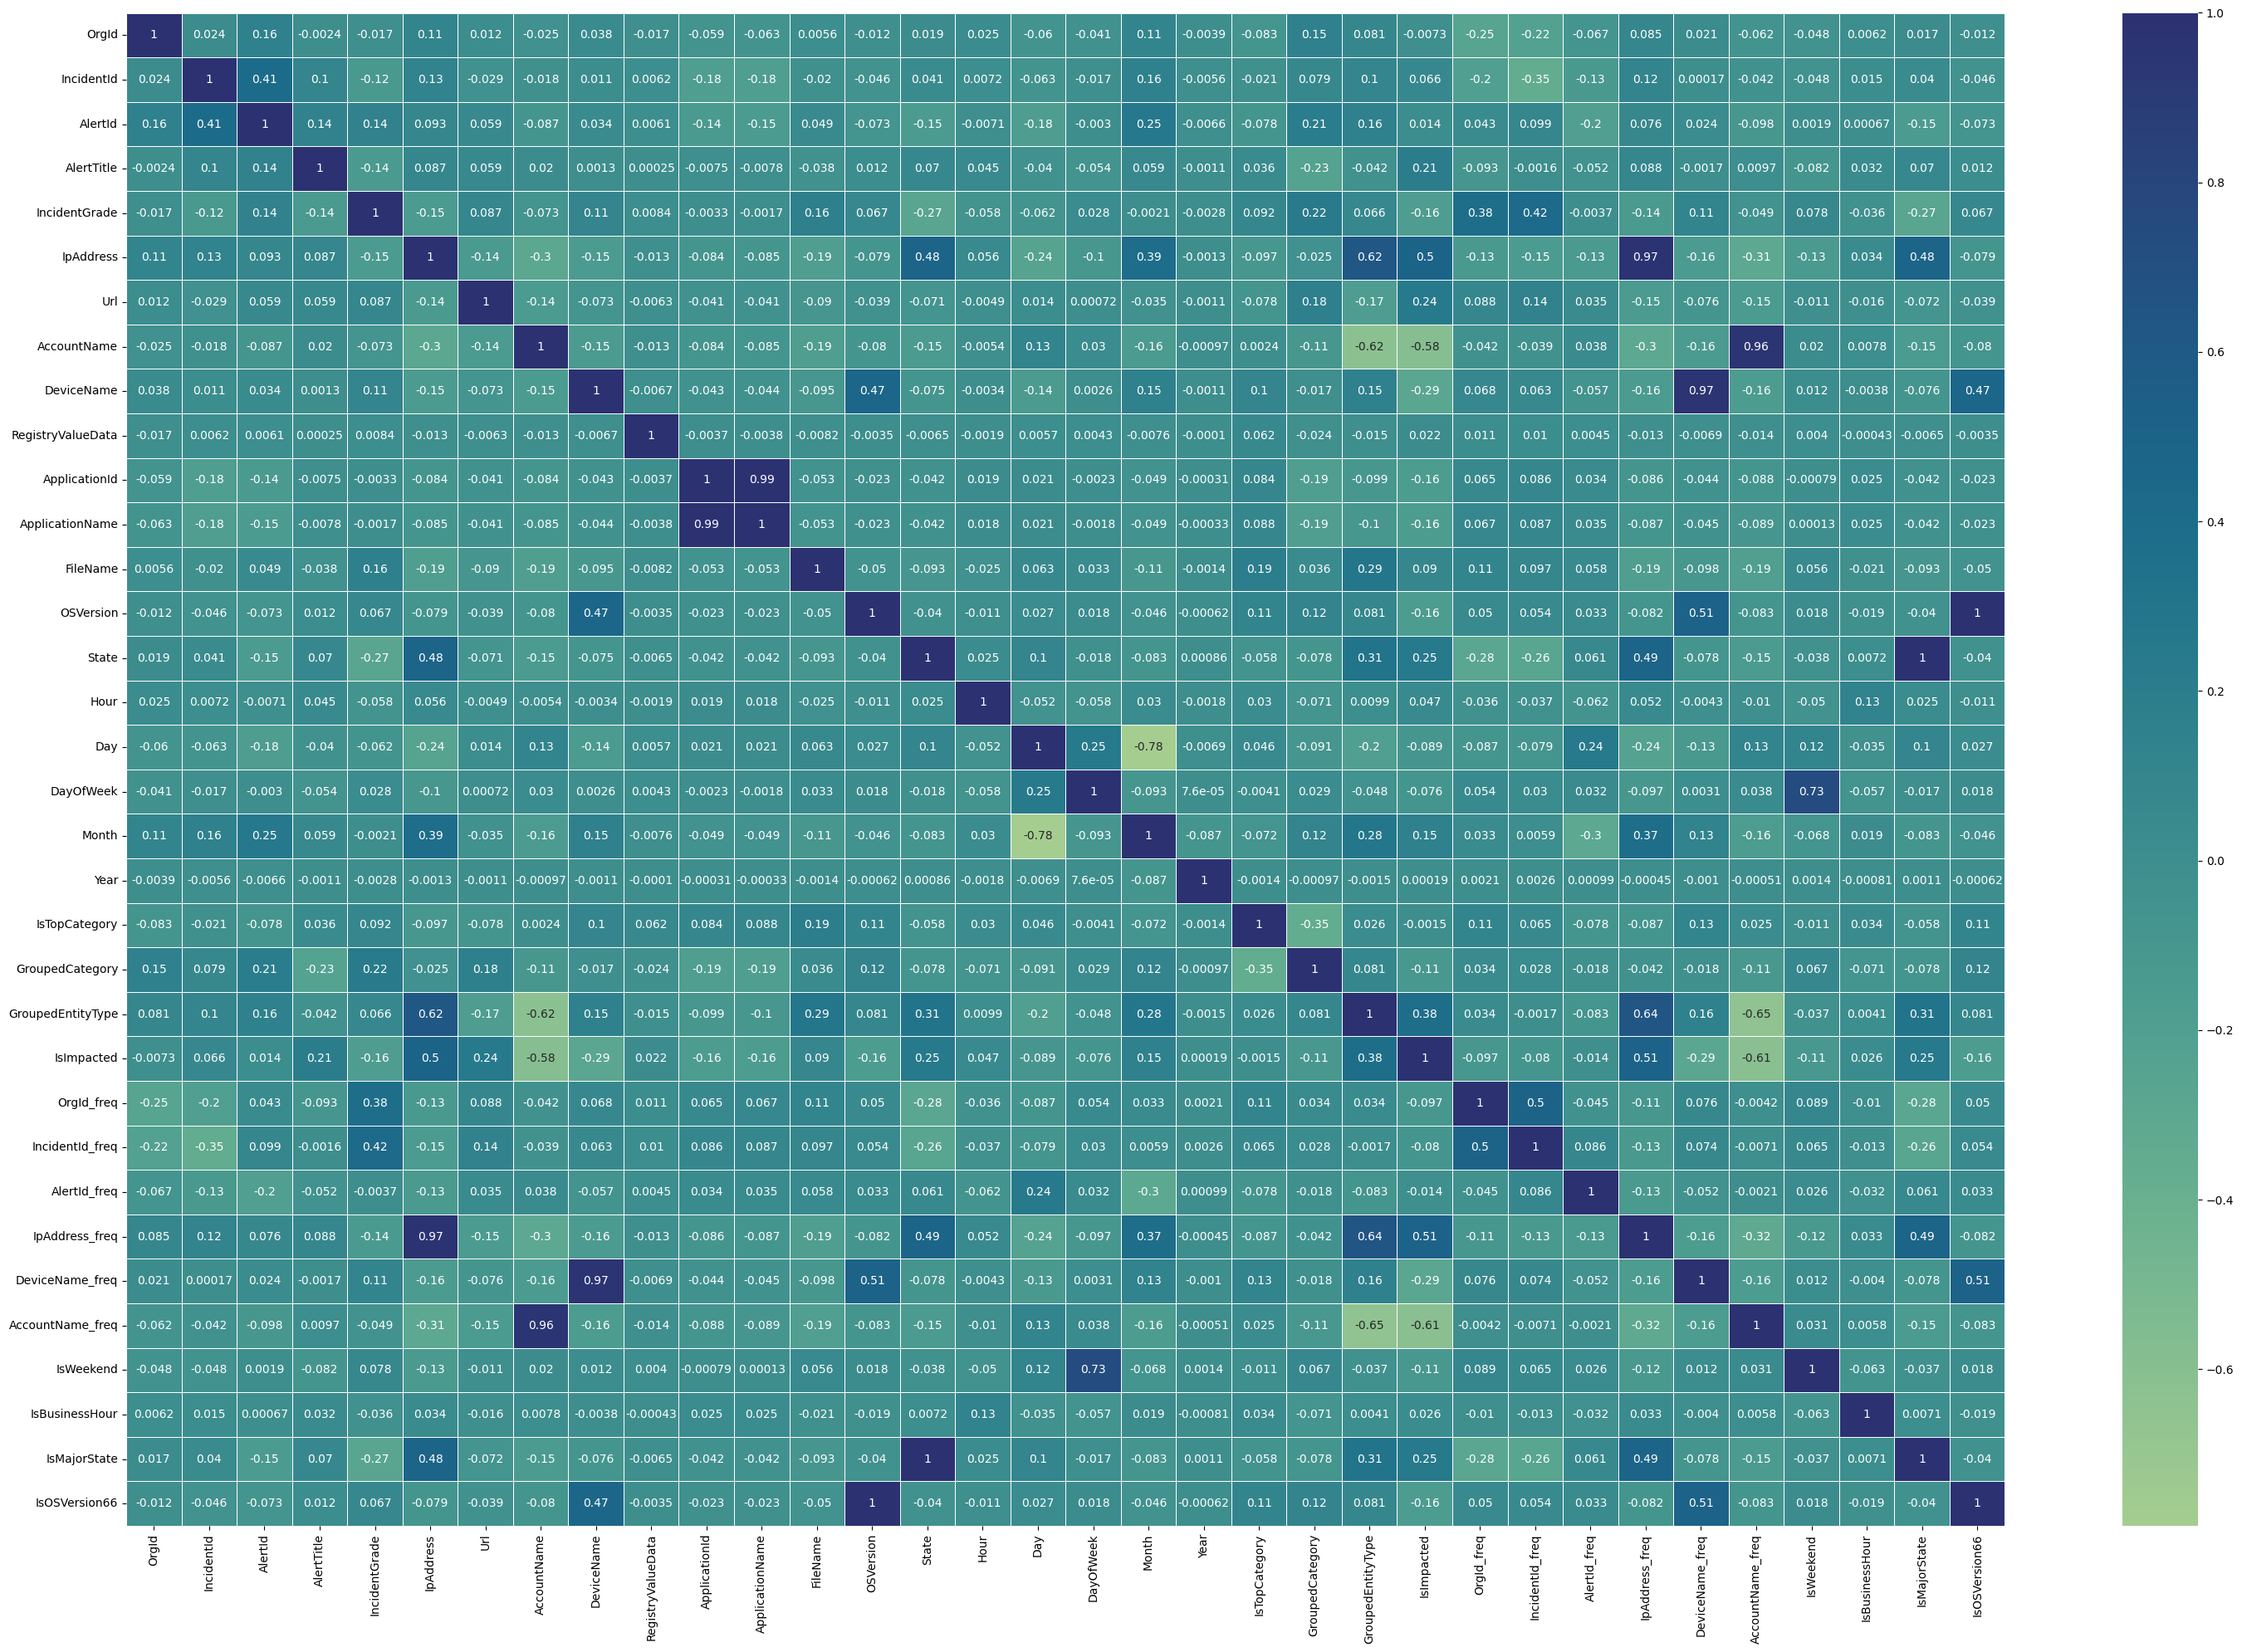

In [ ]:
plt.figure(figsize = (30, 20))
sns.heatmap(feature_engineered_df.corr(), cmap = 'crest', annot = True, linewidth = 0.5)
plt.tight_layout()  
plt.show()

In [ ]:
# save_dir = "pickles"
# os.makedirs(save_dir, exist_ok=True)

# # Save all encoders as a dictionary
# encoders_path = os.path.join(save_dir, "label_encoders.pkl")

# with open(encoders_path, "wb") as le_file:
#     pickle.dump(label_encoders, le_file)
# print(f"Label Encoders saved successfully at: {encoders_path}")